# Measure systematic uncertainties in resolution with Kr data

<i>
This notebook takes a kDST file and a correction file,
applies all corrections (including time) and measures
the variation of the resolution when the corrections
are off by a certain value
</i>

### Notebook configuration

In [1]:
run_number          = 4841
correction_filename = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"
dst_filename        = f"$IC_DATA/Kr/dst_{run_number}_filtered.root.h5"
XY_pitch            =  5.0
Erange              = 33.5, 49.5

XYnbins =  50
Rmax    = 150
Zmax    = 150
Enbins  = 200

# Plotting style
default_cmap        = "jet"
figure_size         = 16, 12
font_size           = 20
global_linewidth    = 4
subfit_linewidth    = 4
global_linecolor    = "r"
subfit_linecolor    = "m g b y".split()
subfit_linecolor    = "b m slategrey c b y".split()

### Imports

In [2]:
import os
import time
import collections
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt
import scipy.optimize    as opt

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.corrections    as corrf
import invisible_cities.reco.dst_functions  as dstf

from invisible_cities.core .stat_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import resolution
from invisible_cities.icaro. hst_functions import gausstext
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import labels
from invisible_cities.icaro. hst_functions import measurement_string

Running on  Fri May 25 16:08:26 2018


### Initialization

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"         ] = figure_size
plt.rcParams[  "font.size"            ] =   font_size
plt.rcParams["figure.max_open_warning"] =        1000

In [4]:
Ebins = np.linspace(*Erange, Enbins + 1)

dst_filename        = os.path.expandvars(       dst_filename)
correction_filename = os.path.expandvars(correction_filename)

### Read data

In [5]:
dst = dstf.load_dst(dst_filename, "DST", "Events")
dst = dst[dst.R < Rmax]
dst = dst[dst.Z < Zmax]
print("Number of S2s   :", len(dst))
print("Number of events:", len(np.unique(dst.event)))
dst.head()

Number of S2s   : 47678
Number of events: 47662


index  event          time  peak  nS2    S1w       S1h        S1e  \
2       14     27  1.510471e+09     0    1  150.0  1.976865   8.930014   
48     163    212  1.510471e+09     0    1  300.0  1.933699  14.853508   
71     225    284  1.510471e+09     0    1  125.0  1.184676   5.218480   
81     251    321  1.510471e+09     0    1  150.0  3.134190  14.412037   
103    318    414  1.510471e+09     0    1  225.0  2.129609  12.513580   

          S1t     S2w    ...            S2t  Nsipm       DT        Z  \
2    859950.0  6.8375    ...      1003500.0     36  143.550  143.550   
48   924400.0  4.7500    ...      1002500.0     39   78.100   78.100   
71   905725.0  7.4125    ...      1002500.0     28   96.775   96.775   
81   890125.0  6.4250    ...      1002500.0     35  112.375  112.375   
103  887700.0  7.4500    ...      1002500.0     37  114.800  114.800   

              X          Y           R       Phi       Xrms       Yrms  
2      5.004905 -31.789076   32.180653 -1.414637  22.182517  29.385406  
48   105.898021 -78.227671  131.658495 -0.636235  36.089057  22.340265  
71   -42.748840   0.487065   42.751614  3.130200  20.713601  26.431054  
81    88.943001  96.766015  131.432565  0.827498  16.158539  11.636134  
103  -74.386531 -20.462867   77.149757 -2.873144  18.678099  18.950670  

[5 rows x 23 columns]

In [6]:
LT_correction0  = dstf.load_lifetime_xy_corrections(correction_filename,
                                                    group = "XYcorrections",
                                                    node  = "Lifetime")

GEO_correction0 = dstf.load_xy_corrections(correction_filename,
                                           group         =  "XYcorrections",
                                           node          = f"GeometryE_{XY_pitch:.1f}mm",
                                           norm_strategy =  "const",
                                           norm_opts     = {"value": 41.5})

In [7]:
T   =(dst.time .values -
      dst.time.values.min()) / 60
S2e = dst.S2e.values
X   = dst.X    .values
Y   = dst.Y    .values
Z   = dst.DT   .values
R   = dst.R    .values
E_  = S2e * LT_correction0(Z, X, Y).value * GEO_correction0(X, Y).value

In [8]:
t, e, eu = fitf.profileX(T, E_, 100)
T_correction0 = corrf.Correction((t,), e, eu, norm_strategy="max")
E = E_ * T_correction0(T).value

##### Input maps

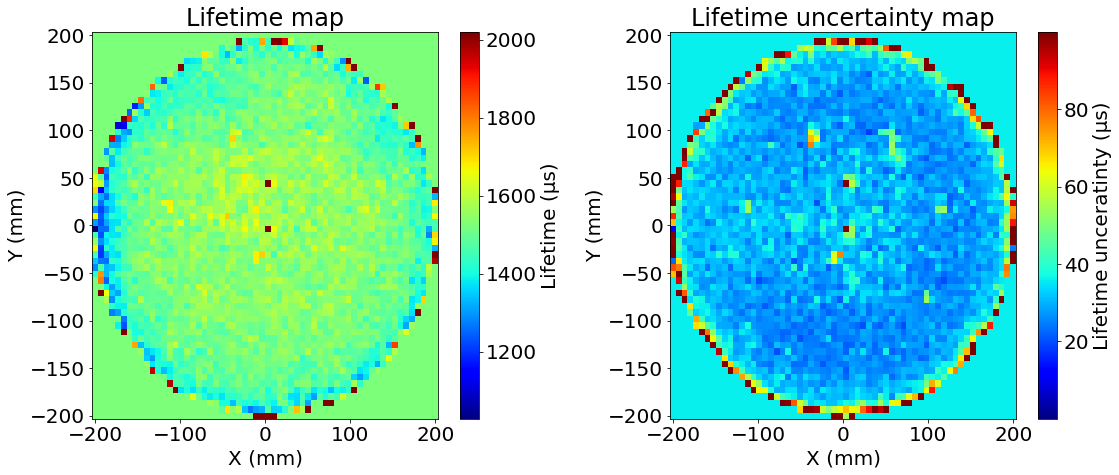

In [9]:
LTmap = dstf.load_dst(correction_filename,
                      group = "XYcorrections",
                      node  = "Lifetime")

x   = np.unique(LTmap.x.values)
y   = np.unique(LTmap.y.values)
LT  = LTmap.factor     .values.reshape(x.size, y.size)
LTu = LTmap.uncertainty.values.reshape(x.size, y.size)

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
*_, cb = display_matrix(x, y, LT,
                        vmin = np.mean(LT) - 2.5 * np.std(LT),
                        vmax = np.mean(LT) + 2.5 * np.std(LT),
                        cmap = default_cmap,
                        new_figure=False)
cb.set_label("Lifetime (µs)")
labels("X (mm)", "Y (mm)", "Lifetime map")

plt.subplot(1, 2, 2)
*_, cb = display_matrix(x, y, LTu,
                        vmin = 1e-3,
                        vmax = np.mean(LTu) + np.std(LTu),
                        cmap = default_cmap,
                        new_figure=False)

cb.set_label("Lifetime unceratinty (µs)")
labels("X (mm)", "Y (mm)", "Lifetime uncertainty map")

plt.tight_layout()

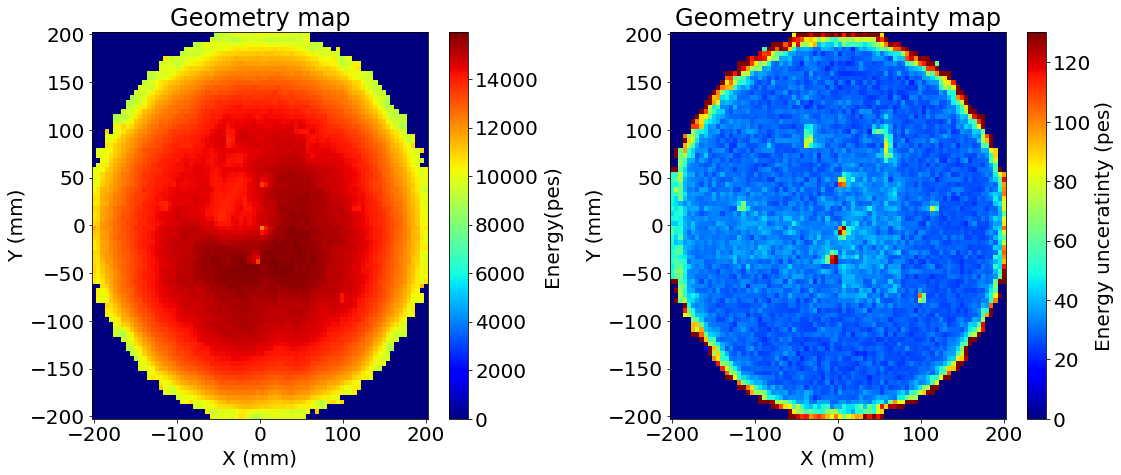

In [10]:
GEOmap = dstf.load_dst(correction_filename,
                       group = "XYcorrections",
                       node  = f"GeometryE_{XY_pitch:.1f}mm")

x  = np.unique(GEOmap.x.values)
y  = np.unique(GEOmap.y.values)
f  = GEOmap.factor     .values.reshape(x.size, y.size)
fu = GEOmap.uncertainty.values.reshape(x.size, y.size)

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
*_, cb = display_matrix(x, y, f,
                        cmap = default_cmap,
                        new_figure=False)
cb.set_label("Energy(pes)")
labels("X (mm)", "Y (mm)", "Geometry map")

plt.subplot(1, 2, 2)
*_, cb = display_matrix(x, y, fu,
                        vmax = np.mean(fu) + 3 * np.std(fu),
                        cmap = default_cmap,
                        new_figure=False)
cb.set_label("Energy unceratinty (pes)")
labels("X (mm)", "Y (mm)", "Geometry uncertainty map")

plt.tight_layout()

##### Energy resolution

In [31]:
xy_data       = collections.namedtuple(      "xy_data", "x y xu yu"       )
reso_fit_data = collections.namedtuple("reso_fit_data", "xy residuals f R")

def measure_resolution(E, *, bkg=fitf.gauss, n_sigma=3.7, nbins=None, degree=2):
    ebins = Ebins if nbins is None else np.linspace(*Erange, nbins + 1)

    y, x  = np.histogram(E, ebins)
    x     = shift_to_bin_centers(x)
    xu    = np.diff(x)[0] * 0.5
    yu    = poisson_sigma(y)

    fun   = lambda x, *args: fitf.gauss(x, *args[:3]) + bkg(x, *args[3:])
    Npeak = np.size(E) * np.diff(Ebins)[0]
    Epeak = np.average( x            , weights=y)
    Speak = np.average((x - Epeak)**2, weights=y)**0.5

    bkg_seed = (Npeak*2, Epeak, Speak*50) if bkg is fitf.gauss else (1 for i in range(degree + 1))
    sig_seed  = Npeak, Epeak, Speak

    seed = np.array((*sig_seed, *bkg_seed))
    seed = np.random.normal(seed, np.abs(seed*0.01))
    fit_range = (Epeak - n_sigma * Speak,
                 Epeak + n_sigma * Speak)
    f    = fitf.fit(fun, x, y, seed,
                    fit_range = fit_range,
                    sigma     = yu,
                    maxfev    = 10000)

    assert not np.any(np.isclose(f.values, seed)), f.values

    R   = resolution(f.values, f.errors, 41.5)
    sel = coref.in_range(x, *fit_range)
    ry  = (f.fn(x) - y) / yu
    return reso_fit_data(xy_data(x, y, xu, yu),
                         xy_data(x[sel], ry[sel], xu, yu[sel]),
                         f, R)

def plot(data, signal=fitf.gauss, bkg=fitf.gauss, title=""):
    print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
    print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
    print("Chi2                  :", data.f.chi2)

    x = data.xy.x
    plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
    plt.plot        (x, data.f.fn   (x)               , lw=global_linewidth, color=global_linecolor   )
    plt.plot        (x, signal(x, *data.f.values[ :3]), lw=subfit_linewidth, color=subfit_linecolor[0])
    plt.fill_between(x, signal(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0])
    plt.plot        (x, bkg   (x, *data.f.values[3: ]), lw=subfit_linewidth, color=subfit_linecolor[1])
    plt.fill_between(x, bkg   (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1])
    plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.03,
             max(data.xy.y) / 1.5,
             gausstext(data.f.values, data.f.errors, 41.5))
    plt.ylim(0)
    labels("E (keV)", "Entries", title)
    
def relative_to(x, fraction=0.5):
    return x[0] + np.diff(x) * fraction

## Reference value

Resolution at 41.5 keV: 3.912 +- 0.020
Resolution at 2458 keV: 0.5083 +- 0.0027
Chi2                  : 1.0987639705


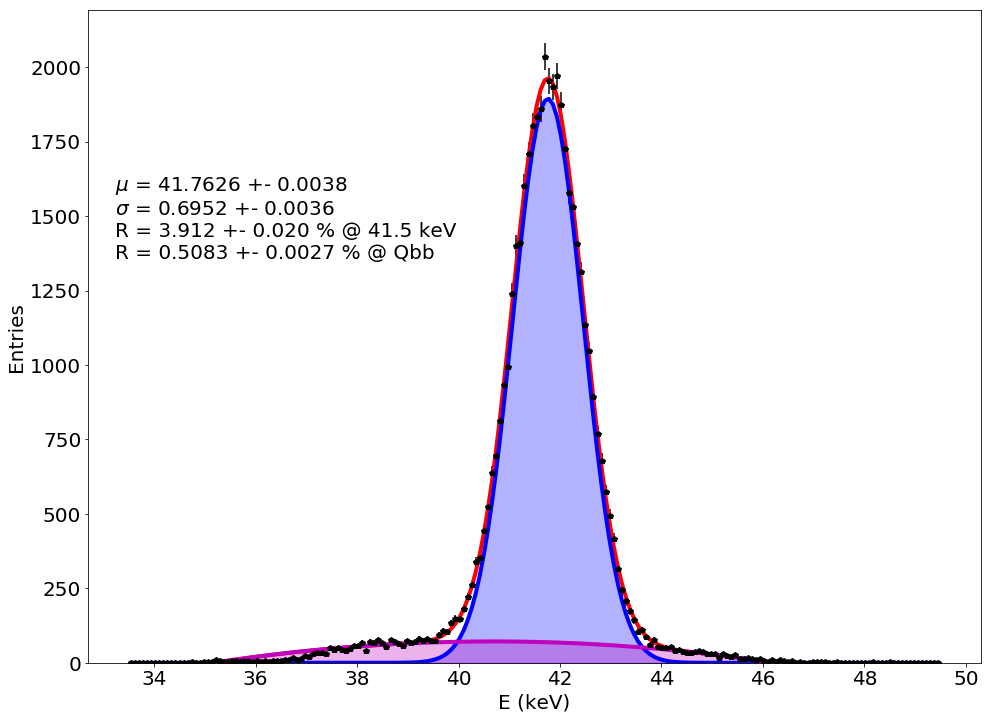

In [12]:
bkg  = fitf.polynom
data = measure_resolution(E, bkg=bkg)
plot(data, bkg=bkg)
true_ylim = plt.ylim()

## Lifetime systematics

In [13]:
nsigmas_lt = 20
n_it       = 20
bkg        = fitf.polynom

sigmas_lt = np.linspace(-5, 5, nsigmas_lt)
E0        = S2e * GEO_correction0(X, Y).value * T_correction0(T).value

LTdst = dstf.load_dst(correction_filename,
                      group = "XYcorrections",
                      node  = "Lifetime")
Xs    = np.unique(LTdst.x.values)
Ys    = np.unique(LTdst.y.values)
LTs   = LTdst.factor     .values.reshape(Xs.size, Ys.size)
LTus  = LTdst.uncertainty.values.reshape(Xs.size, Ys.size)

R_lt  = np.zeros(nsigmas_lt)
Ru_lt = np.zeros(nsigmas_lt)

for i, nsig in enumerate(sigmas_lt):
    r = np.full(n_it, np.nan)
    u = np.full(n_it, np.nan)
    for j in range(n_it):
        sign = np.random.choice([-1, 1], size=LTs.shape)
        lt = corrf.Correction((Xs, Ys), LTs + nsig * LTus * sign, LTus)
        LT_correction = lambda z, x, y: corrf.LifetimeCorrection(*lt(x, y))(z)
        e = E0 * LT_correction(Z, X, Y).value
        try:
            data = measure_resolution(e, bkg=bkg)
            r[j], u[j] = data.R[0]
        except AssertionError:
            pass
    w  = u**-2
    ok = ~(np.isnan(r) | np.isnan(u))
    
    R_lt [i] = np.average( r[ok]              , weights=w[ok])
    Ru_lt[i] = np.average((r[ok] - R_lt[i])**2, weights=w[ok])**0.5

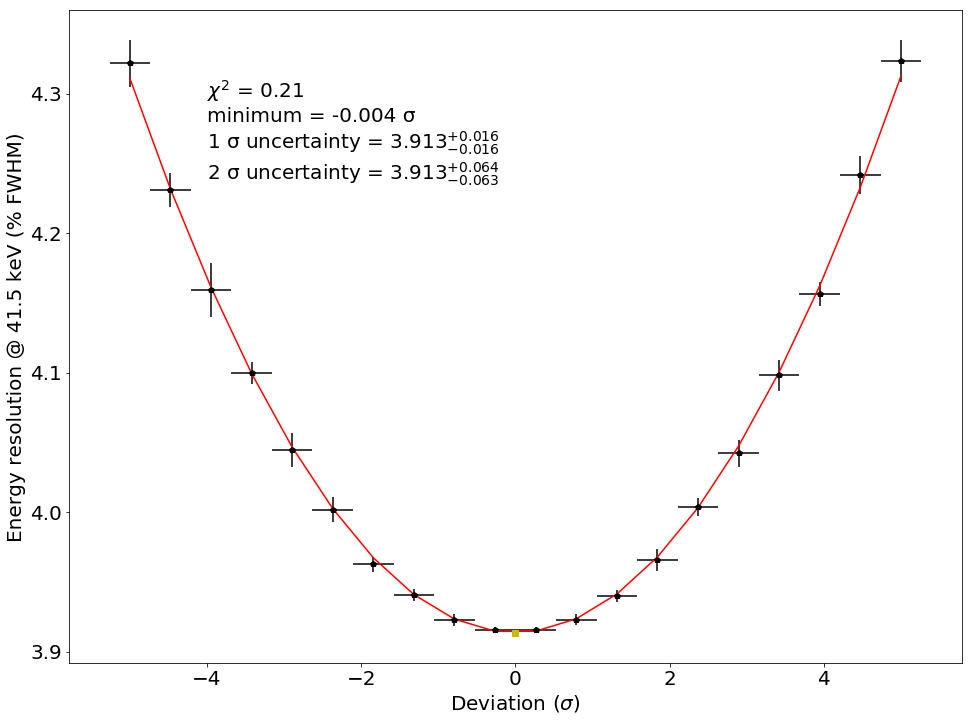

In [14]:
seed = np.ones(3)
f    = fitf.fit(fitf.polynom, sigmas_lt, R_lt, seed, sigma=Ru_lt)

min_data = opt.minimize(f.fn, 0)
min_x    = min_data.x[0]
min_y    = min_data.fun
reso_0   = f.fn( 0)
reso_m1  = f.fn(-1)
reso_p1  = f.fn(+1)
reso_m2  = f.fn(-2)
reso_p2  = f.fn(+2)
delta_m1 = reso_m1 - reso_0
delta_p1 = reso_p1 - reso_0
delta_m2 = reso_m2 - reso_0
delta_p2 = reso_p2 - reso_0

text = f"""
$\chi^2$ = {f.chi2:.2f}
minimum = {min_x:.3f} σ
1 σ uncertainty = ${reso_0:.3f}_{{-{delta_m1:.3f}}}^{{+{delta_p1:.3f}}}$
2 σ uncertainty = ${reso_0:.3f}_{{-{delta_m2:.3f}}}^{{+{delta_p2:.3f}}}$
"""

plt.errorbar(sigmas_lt, R_lt, Ru_lt, np.diff(sigmas_lt)[0]/2, "pk")
plt.plot    (sigmas_lt, f.fn(sigmas_lt), "r-")
plt.plot    (min_x, min_y, "sy")
plt.text    (-4, relative_to(plt.ylim(), 0.7), text)

labels("Deviation ($\sigma$)", "Energy resolution @ 41.5 keV (% FWHM)")

## Geometry uncertainties

In [15]:
nsigmas_geo = 15
n_it        = 20
bkg         = fitf.polynom

sigmas_geo = np.linspace(-5, 5, nsigmas_geo) 
E0         = S2e * LT_correction0(Z, X, Y).value * T_correction0(T).value

GEOdst = dstf.load_dst(correction_filename,
                       group = "XYcorrections",
                       node  = f"GeometryE_{XY_pitch:.1f}mm")
Xs     = np.unique(GEOdst.x.values)
Ys     = np.unique(GEOdst.y.values)
Fs     = GEOdst.factor     .values.reshape(Xs.size, Ys.size)
Fus    = GEOdst.uncertainty.values.reshape(Xs.size, Ys.size)

R_geo  = np.zeros (nsigmas_geo)
Ru_geo = np.zeros (nsigmas_geo)

for i, nsig in enumerate(sigmas_geo):
    r = np.full(n_it, np.nan)
    u = np.full(n_it, np.nan)
    for j in range(n_it):
        sign = np.random.choice([-1, 1], size=Fs.shape)
        GEO_correction = corrf.Correction((Xs, Ys), Fs + nsig * Fus * sign, Fus,
                                          norm_strategy="const", norm_opts={"value": 41.5})
        e = E0 * GEO_correction(X, Y).value
        try:
            data = measure_resolution(e, bkg=bkg)
            r[j], u[j] = data.R[0]
        except AssertionError:
            pass
    w  = u**-2
    ok = ~(np.isnan(r) | np.isnan(u))
    
    R_geo [i] = np.average( r[ok]               , weights=w[ok])
    Ru_geo[i] = np.average((r[ok] - R_geo[i])**2, weights=w[ok])**0.5

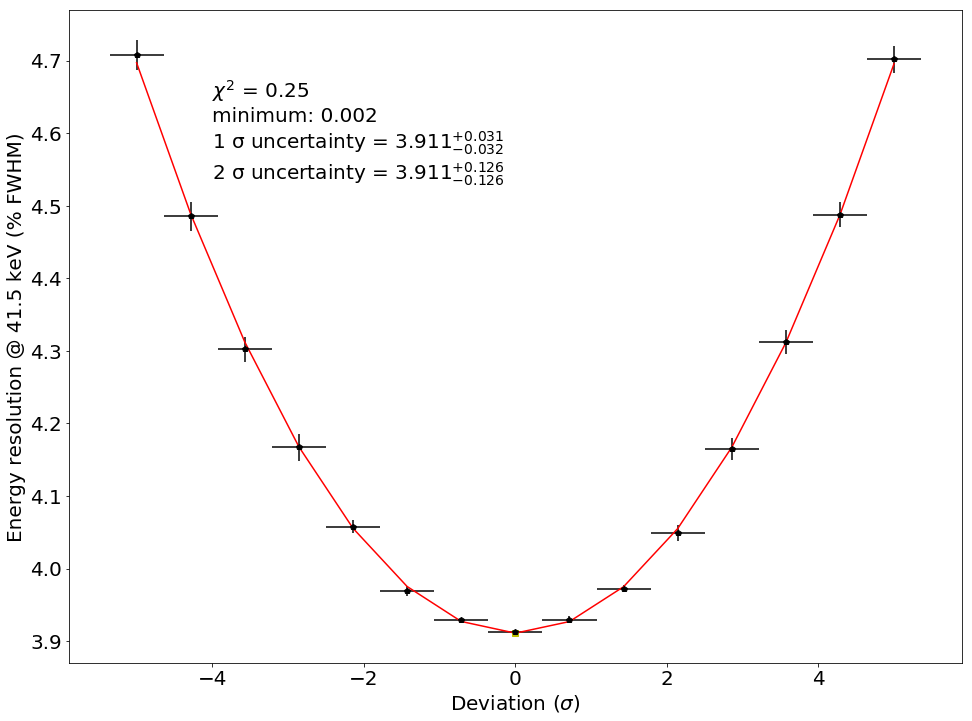

In [16]:
seed = np.ones(3)
f    = fitf.fit(fitf.polynom, sigmas_geo[Ru_geo > 0], R_geo[Ru_geo > 0], seed, sigma=Ru_geo[Ru_geo > 0])

min_data = opt.minimize(f.fn, 0)
min_x    = min_data.x[0]
min_y    = min_data.fun
reso_0   = f.fn( 0)
reso_m1  = f.fn(-1)
reso_p1  = f.fn(+1)
reso_m2  = f.fn(-2)
reso_p2  = f.fn(+2)
delta_m1 = reso_m1 - reso_0
delta_p1 = reso_p1 - reso_0
delta_m2 = reso_m2 - reso_0
delta_p2 = reso_p2 - reso_0

text = f"""
$\chi^2$ = {f.chi2:.2f}
minimum: {min_x:.3f}
1 σ uncertainty = ${reso_0:.3f}_{{-{delta_m1:.3f}}}^{{+{delta_p1:.3f}}}$
2 σ uncertainty = ${reso_0:.3f}_{{-{delta_m2:.3f}}}^{{+{delta_p2:.3f}}}$
"""

plt.errorbar(sigmas_geo, R_geo, Ru_geo, np.diff(sigmas_geo)[0]/2, "pk")
plt.plot    (sigmas_geo, f.fn(sigmas_geo), "r-")
plt.plot    (min_x, min_y, "sy")
plt.text    (-4, relative_to(plt.ylim(), 0.7), text)

labels("Deviation ($\sigma$)", "Energy resolution @ 41.5 keV (% FWHM)")

## Binning systematics

In [26]:
bkg      = fitf.polynom
nbins    = np.arange(50, 1000, 21)
R_nbins  = np.zeros(nbins.size)
Ru_nbins = np.zeros(nbins.size)
for i, n in enumerate(nbins):
    data = measure_resolution(E, bkg=bkg, n_sigma=2.5, nbins=n)
    R_nbins[i], Ru_nbins[i] = data.R[0]

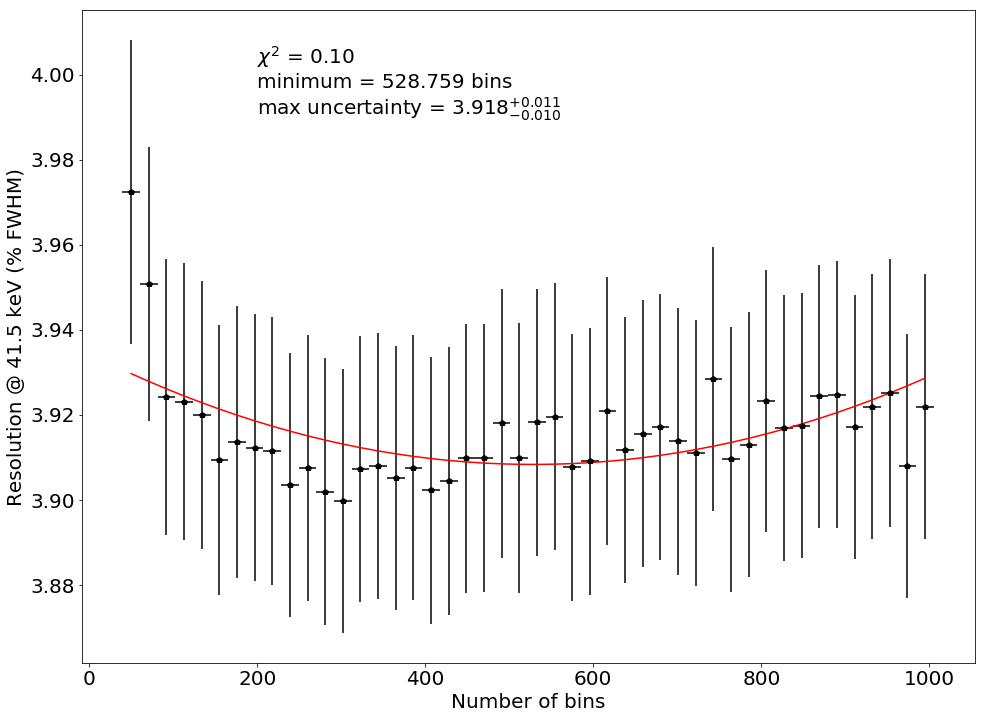

In [27]:
### seed = np.ones(3)
f = fitf.fit(fitf.polynom, nbins[~np.isnan(Ru_nbins)], R_nbins[~np.isnan(Ru_nbins)], seed, sigma=Ru_nbins[~np.isnan(Ru_nbins)])

min_data = opt.minimize(f.fn, 0)
max_data = opt.minimize(lambda x: -f.fn(x), 0, bounds=((nbins[0], nbins[-1]),))
min_x    = min_data.x[0]
max_x    = max_data.x[0]
min_y    = f.fn(min_x)
max_y    = f.fn(max_x)
reso_0   = f.fn( 200 )
delta_m  = abs(min_y - reso_0)
delta_p  = abs(max_y - reso_0)

text = f"""
$\chi^2$ = {f.chi2:.2f}
minimum = {min_x:.3f} bins
max uncertainty = ${reso_0:.3f}_{{-{delta_m:.3f}}}^{{+{delta_p:.3f}}}$
"""

plt.errorbar(nbins, R_nbins, Ru_nbins, np.diff(nbins)[0] / 2, "pk")
plt.plot(nbins, f.fn(nbins), "r-")
plt.text(200, relative_to(plt.ylim(), 0.8), text)

labels("Number of bins", "Resolution @ 41.5 keV (% FWHM)")

### Fit range systematics

Resolution at 41.5 keV: 3.919 +- 0.023
Resolution at 2458 keV: 0.5092 +- 0.0030
Chi2                  : 1.08809282396
Resolution at 41.5 keV: 3.919 +- 0.022
Resolution at 2458 keV: 0.5092 +- 0.0029
Chi2                  : 1.07058426046
Resolution at 41.5 keV: 3.919 +- 0.022
Resolution at 2458 keV: 0.5092 +- 0.0029
Chi2                  : 1.07058426046
Resolution at 41.5 keV: 3.919 +- 0.022
Resolution at 2458 keV: 0.5092 +- 0.0029
Chi2                  : 1.07058426046
Resolution at 41.5 keV: 3.919 +- 0.022
Resolution at 2458 keV: 0.5092 +- 0.0028
Chi2                  : 1.04911686968
Resolution at 41.5 keV: 3.919 +- 0.022
Resolution at 2458 keV: 0.5092 +- 0.0028
Chi2                  : 1.04911686968
Resolution at 41.5 keV: 3.919 +- 0.022
Resolution at 2458 keV: 0.5092 +- 0.0028
Chi2                  : 1.0942595332
Resolution at 41.5 keV: 3.919 +- 0.022
Resolution at 2458 keV: 0.5092 +- 0.0028
Chi2                  : 1.0942595332
Resolution at 41.5 keV: 3.919 +- 0.022
Resolution at 2458 

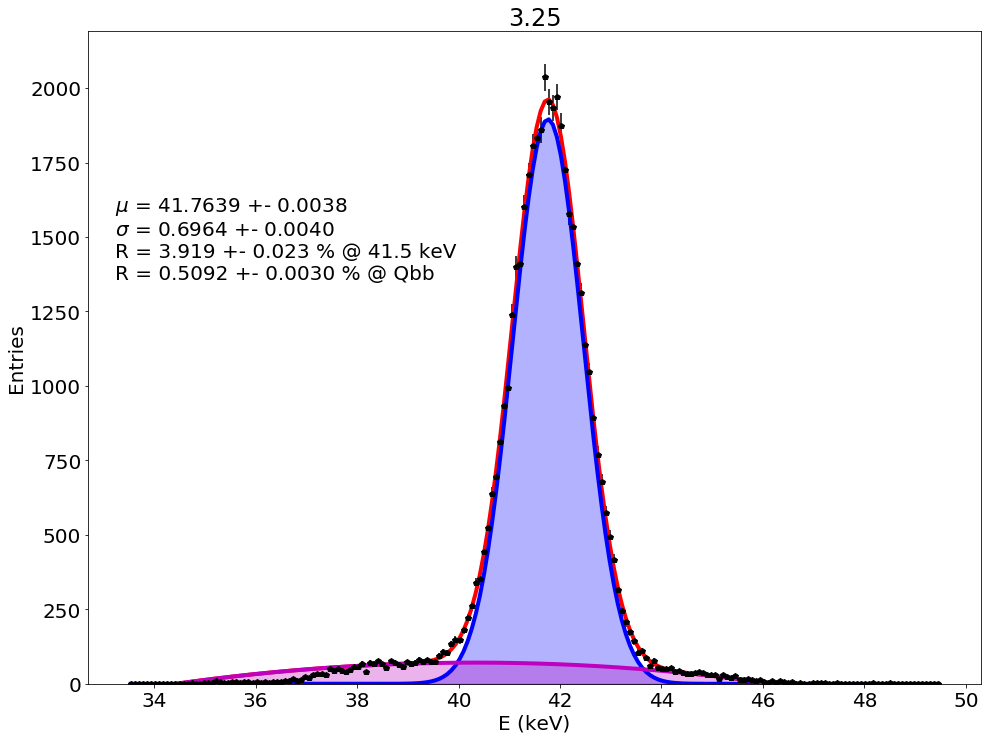

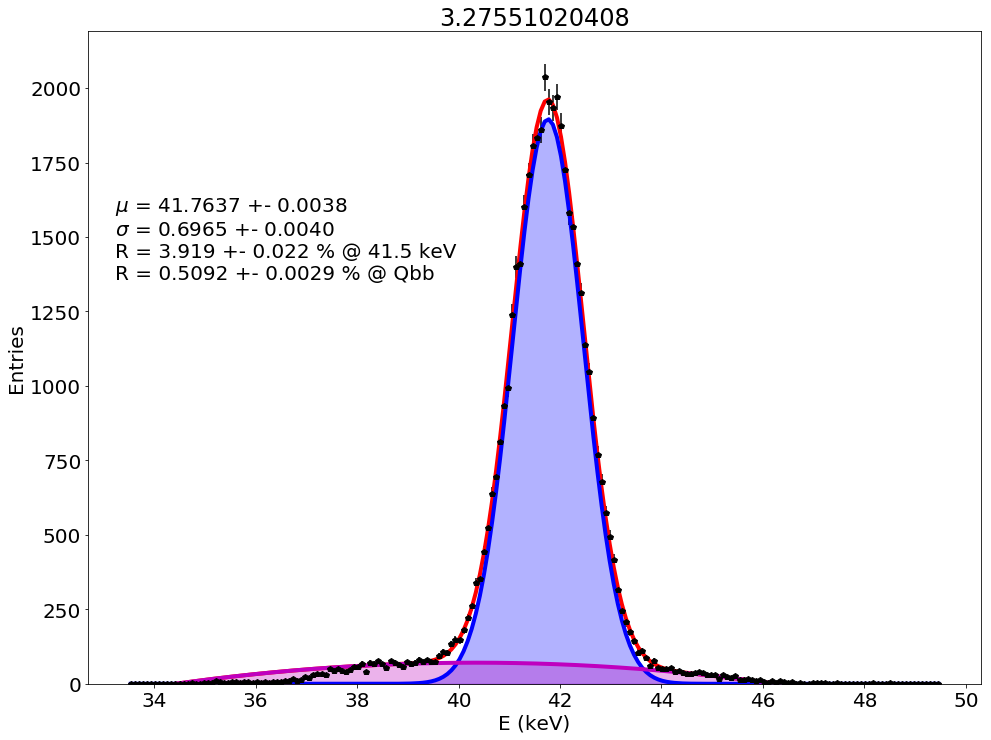

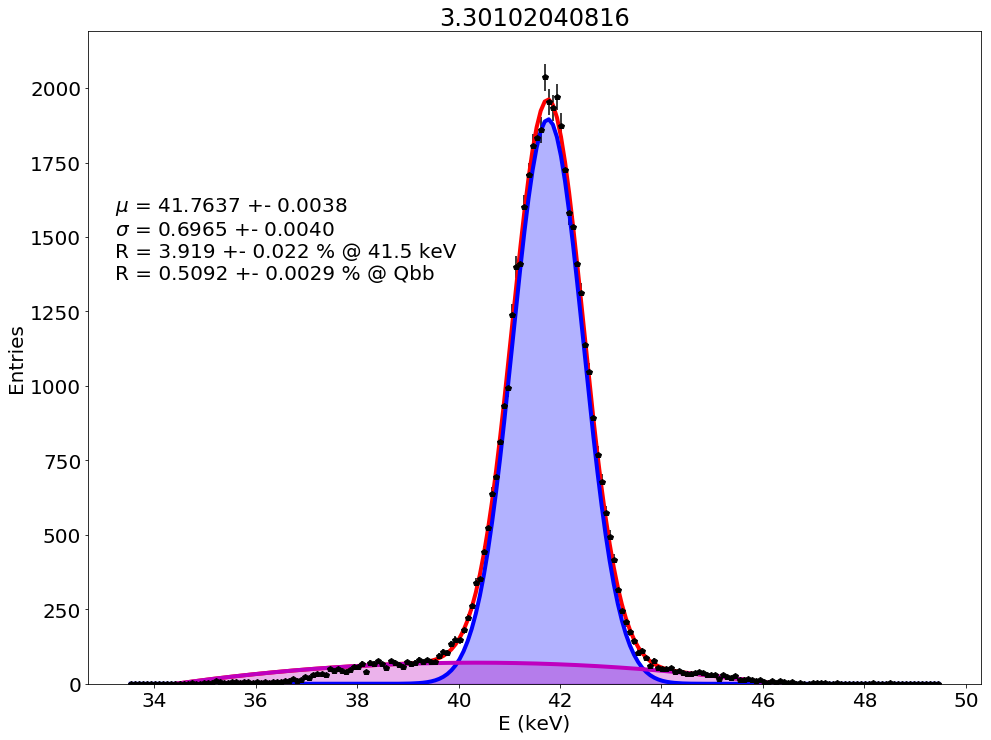

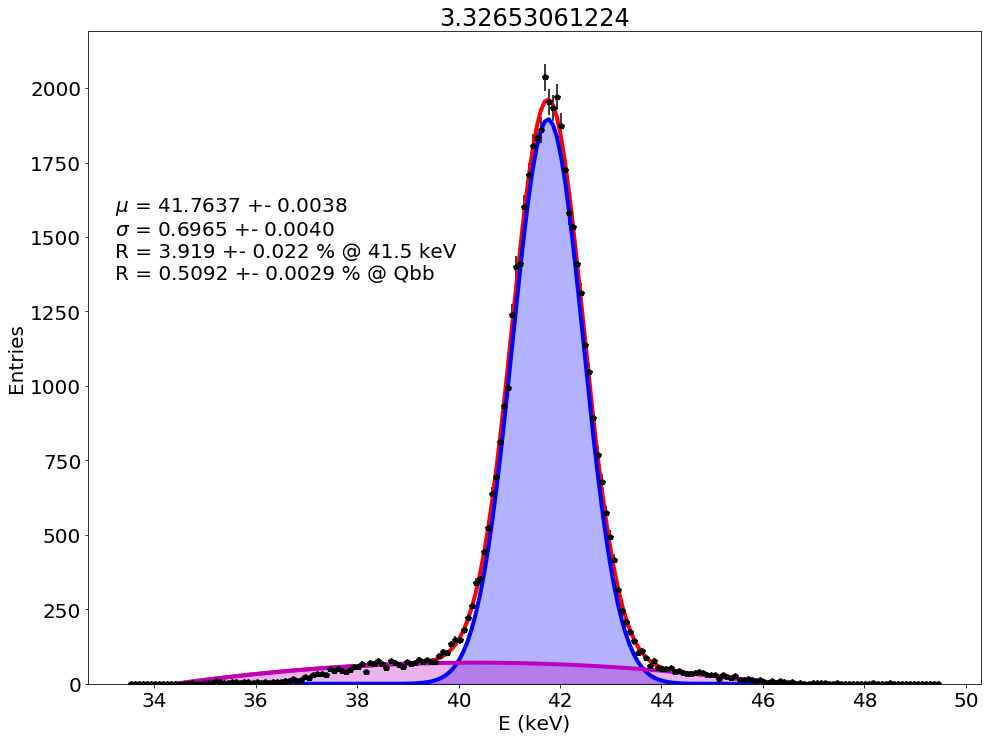

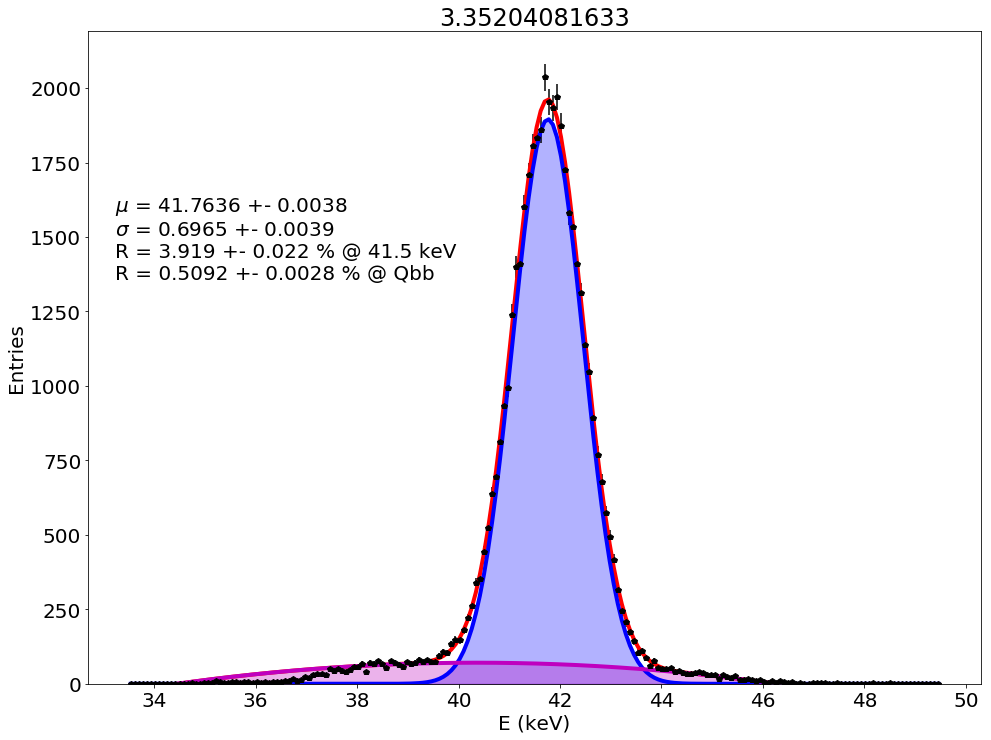

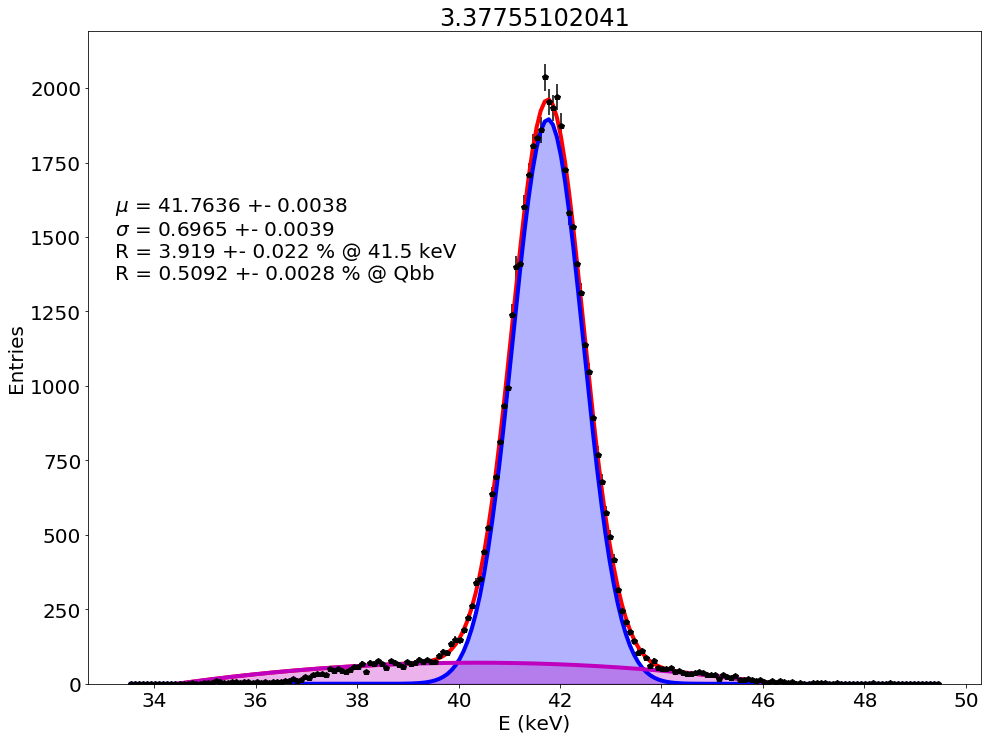

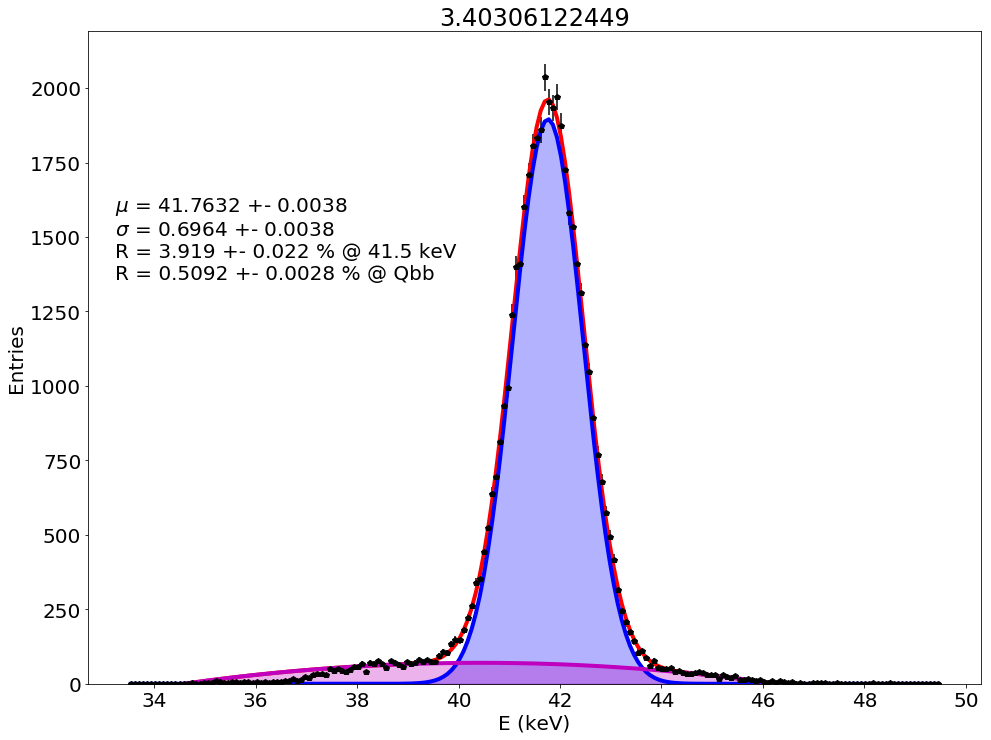

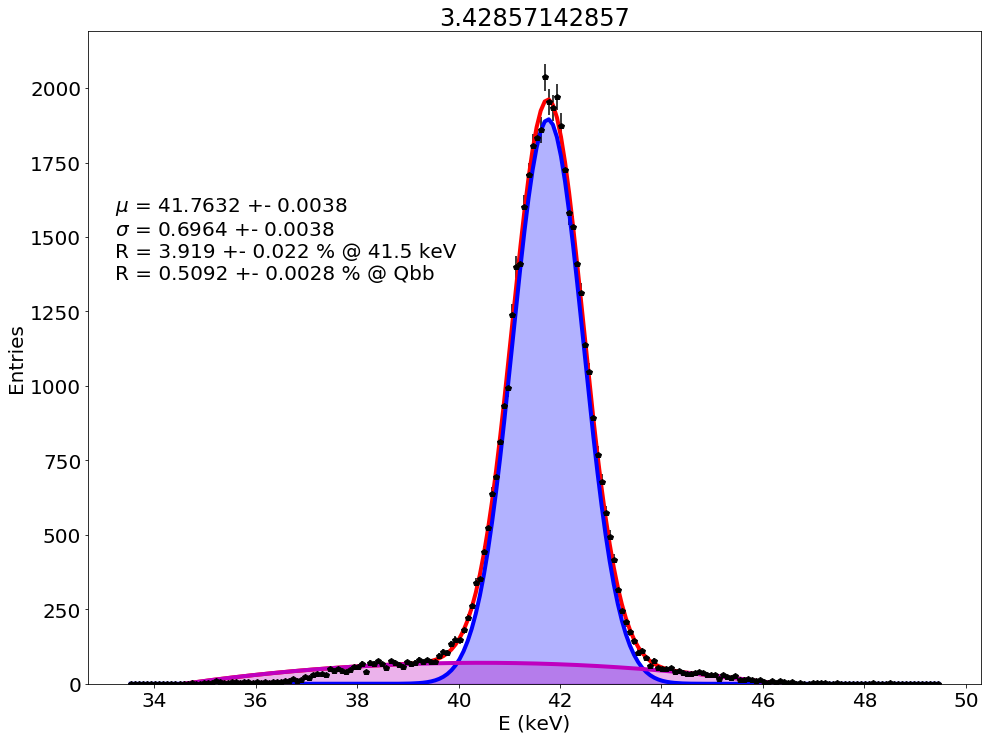

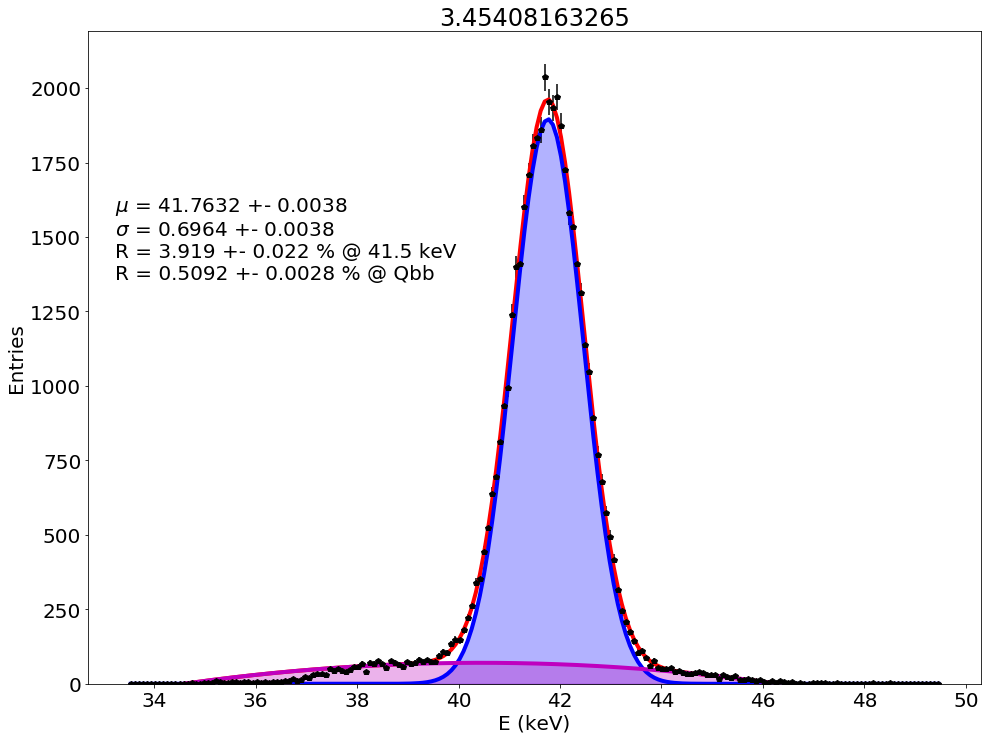

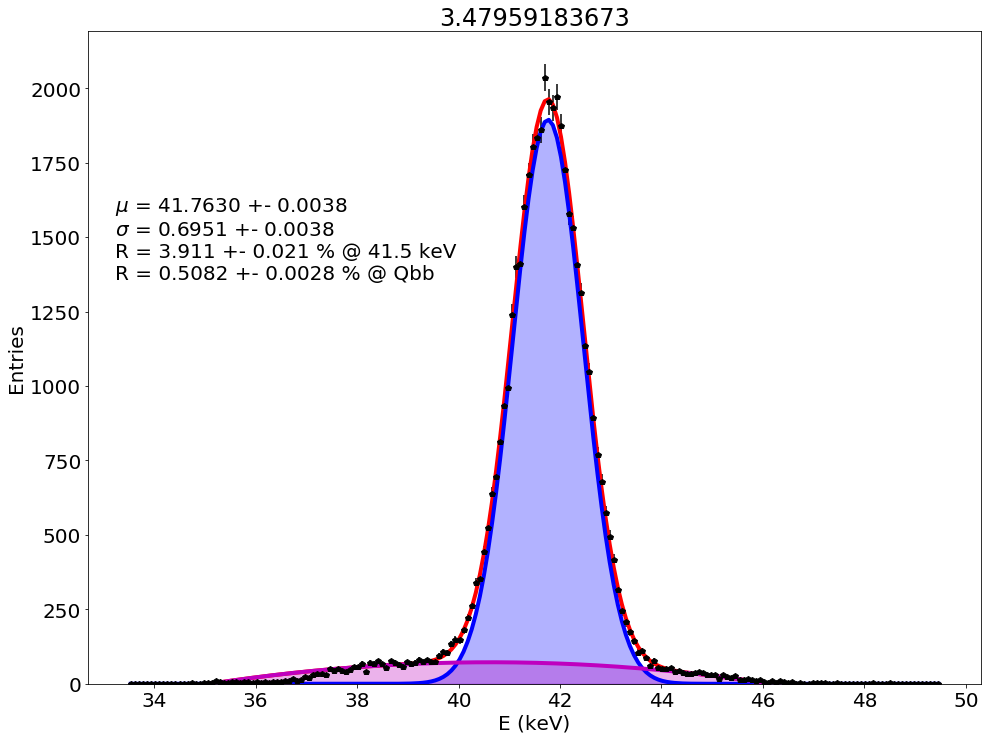

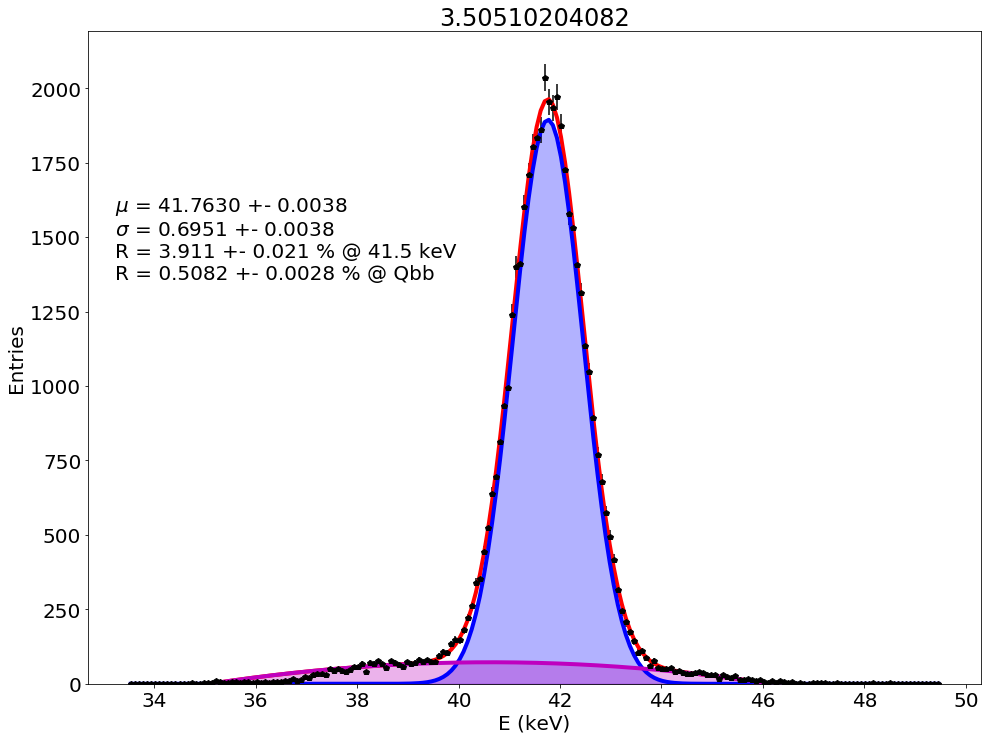

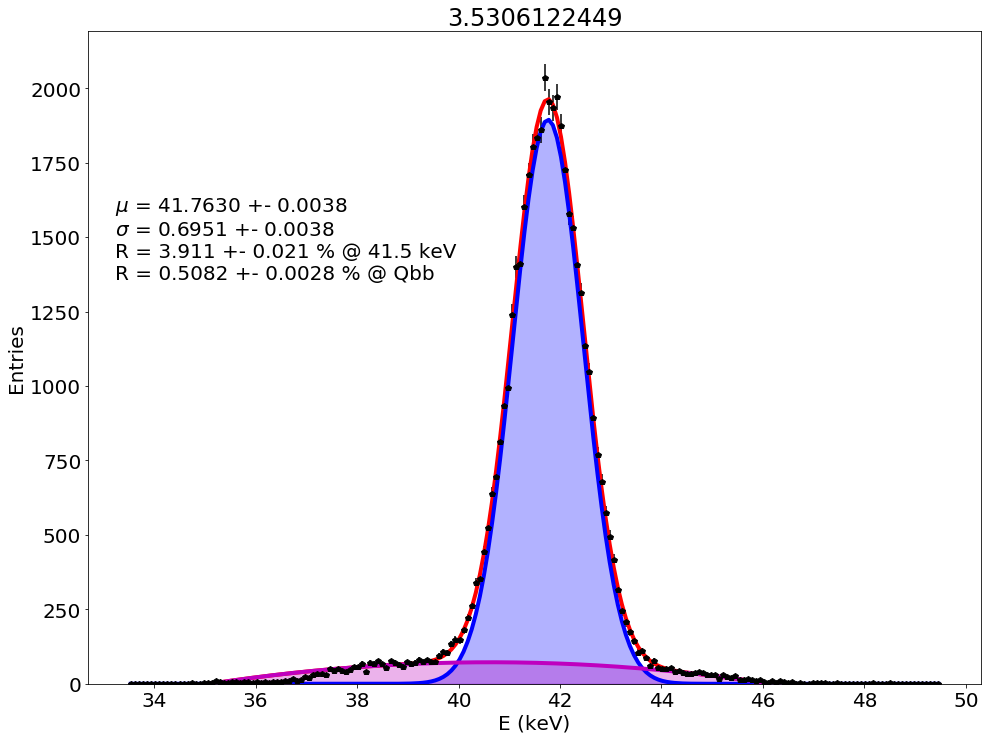

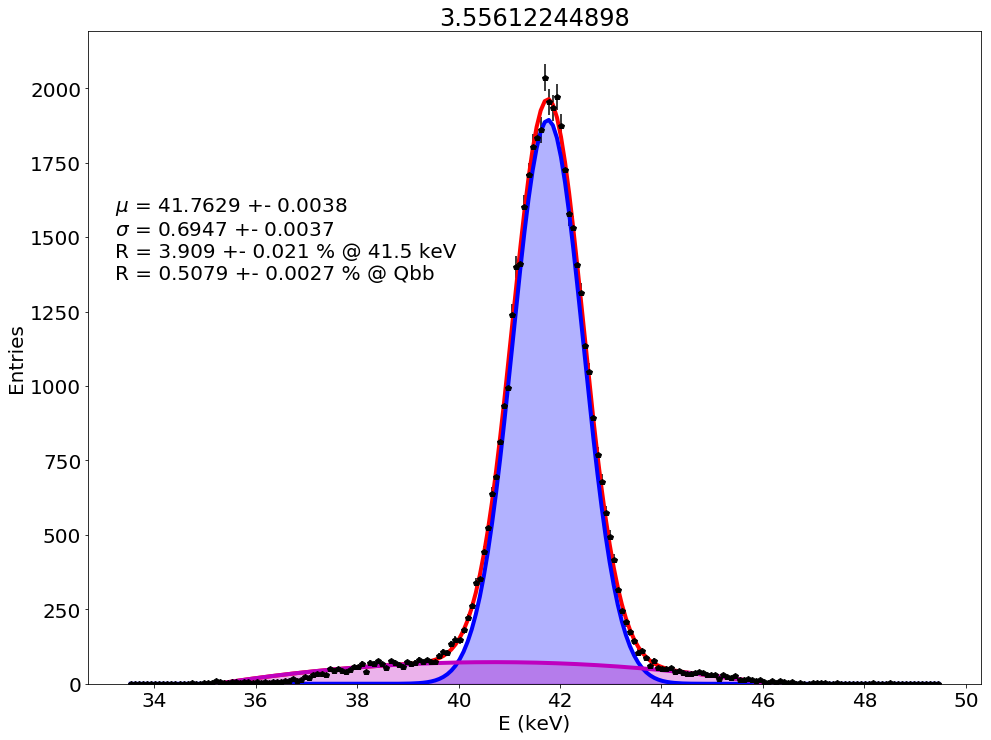

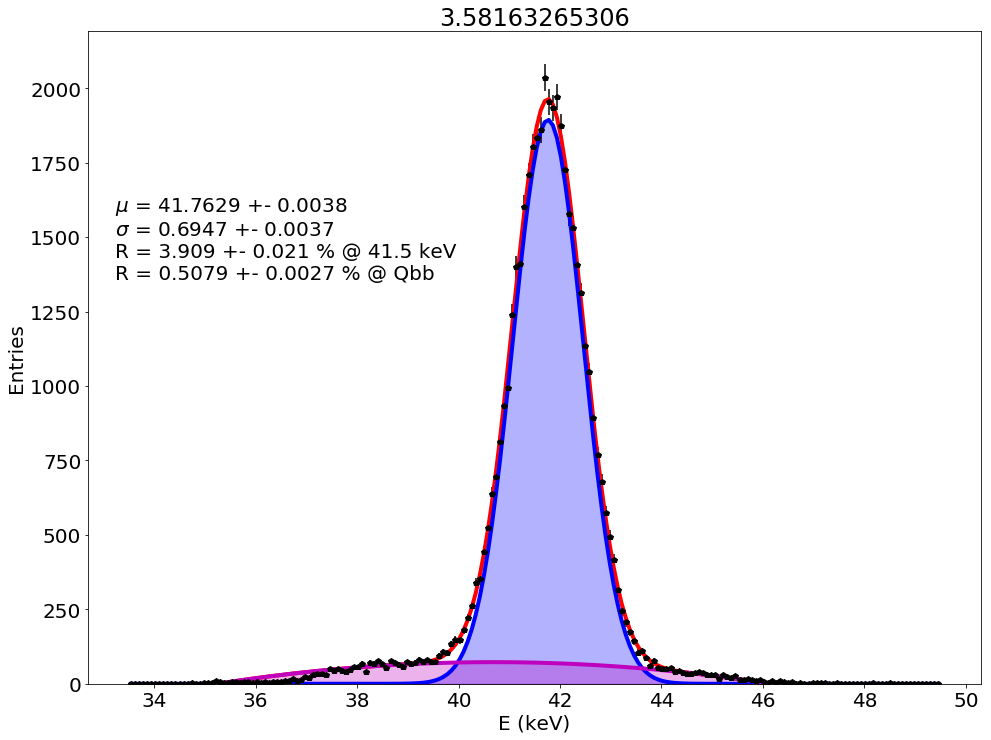

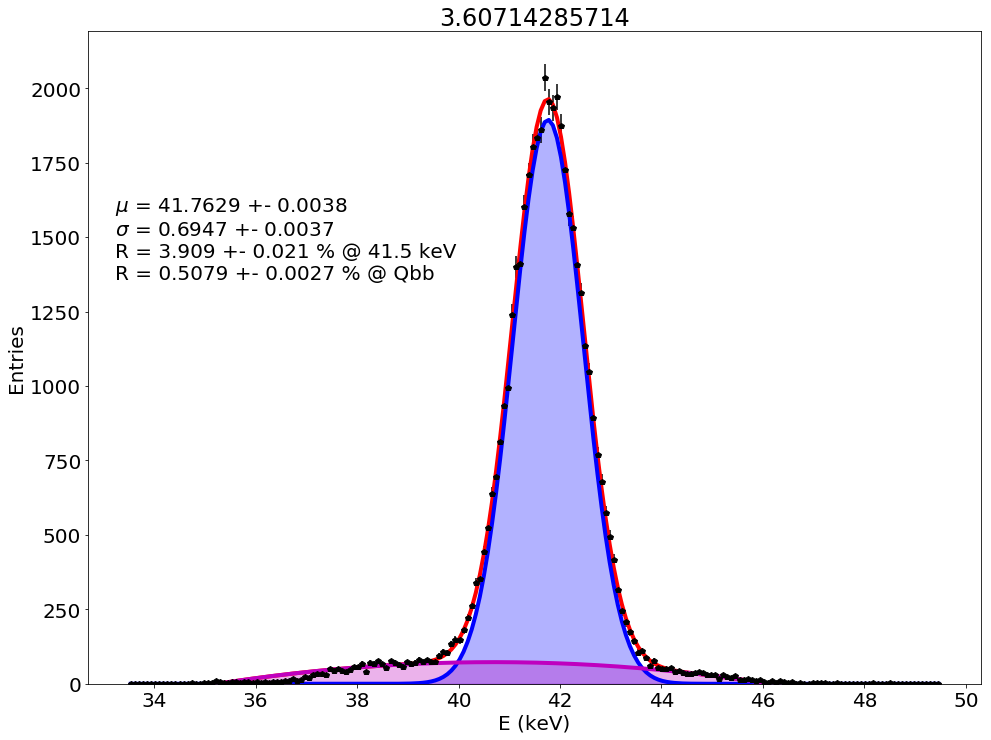

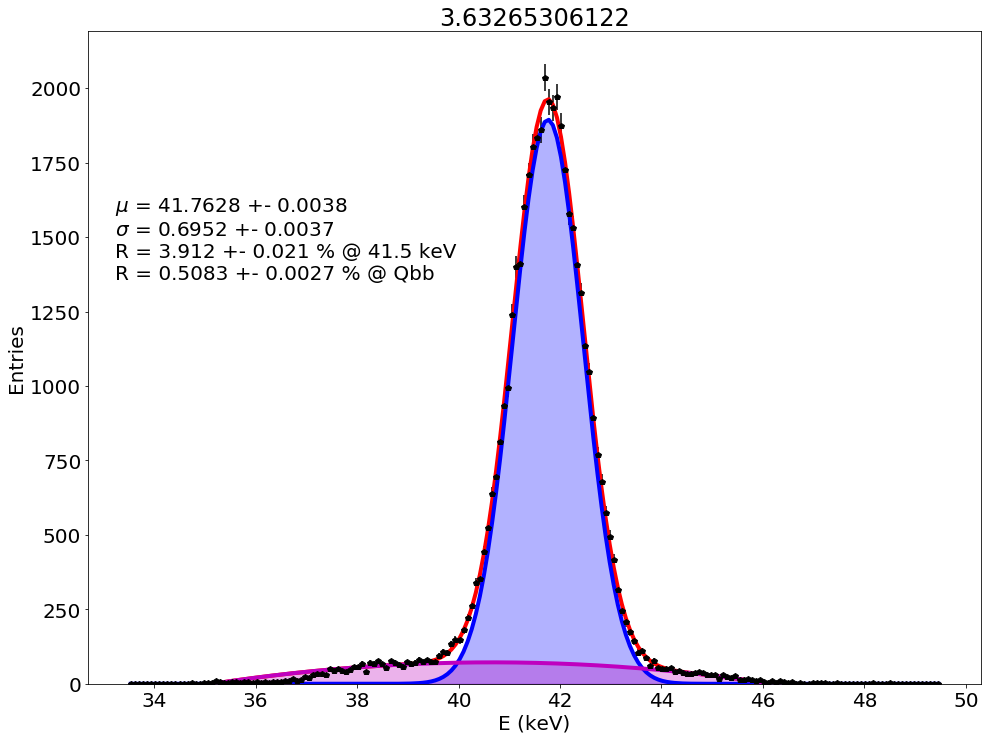

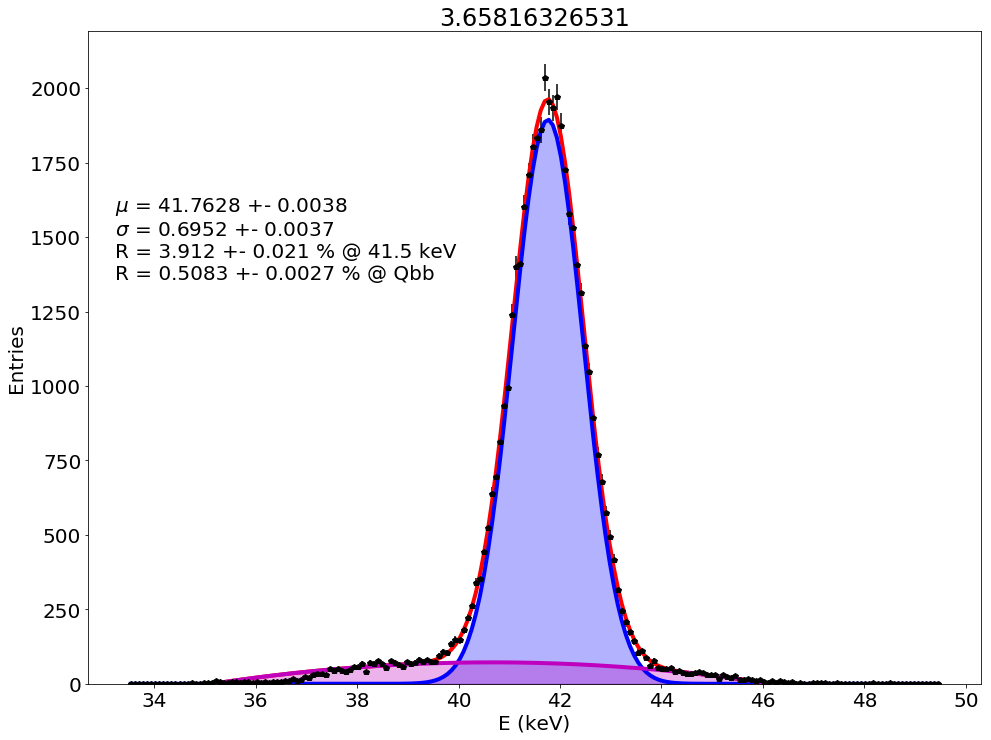

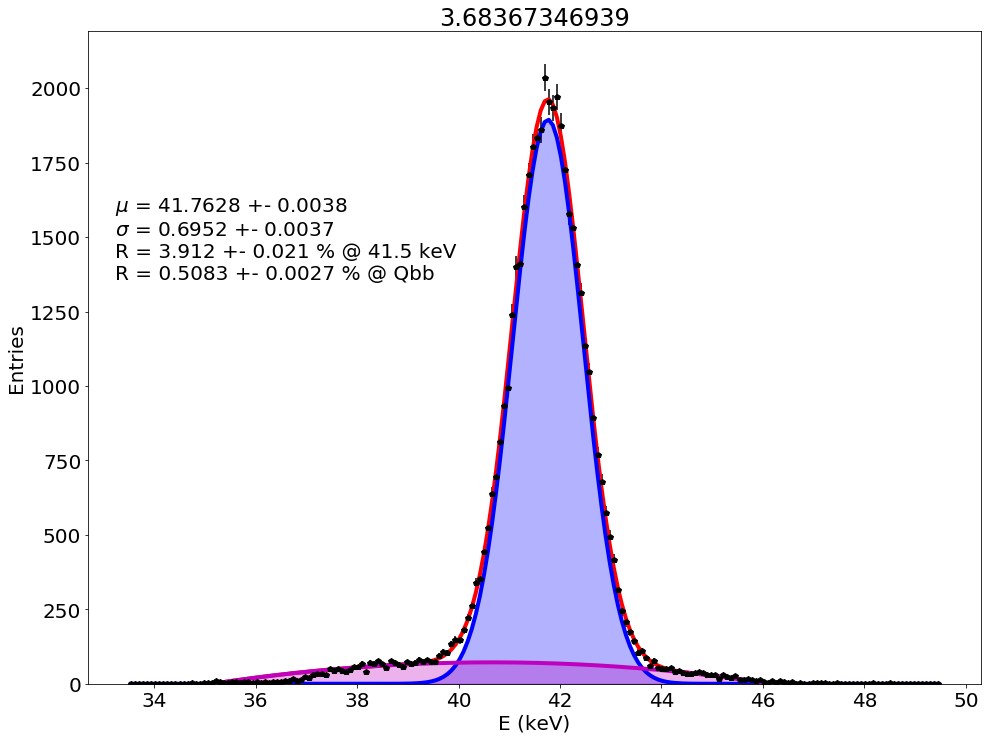

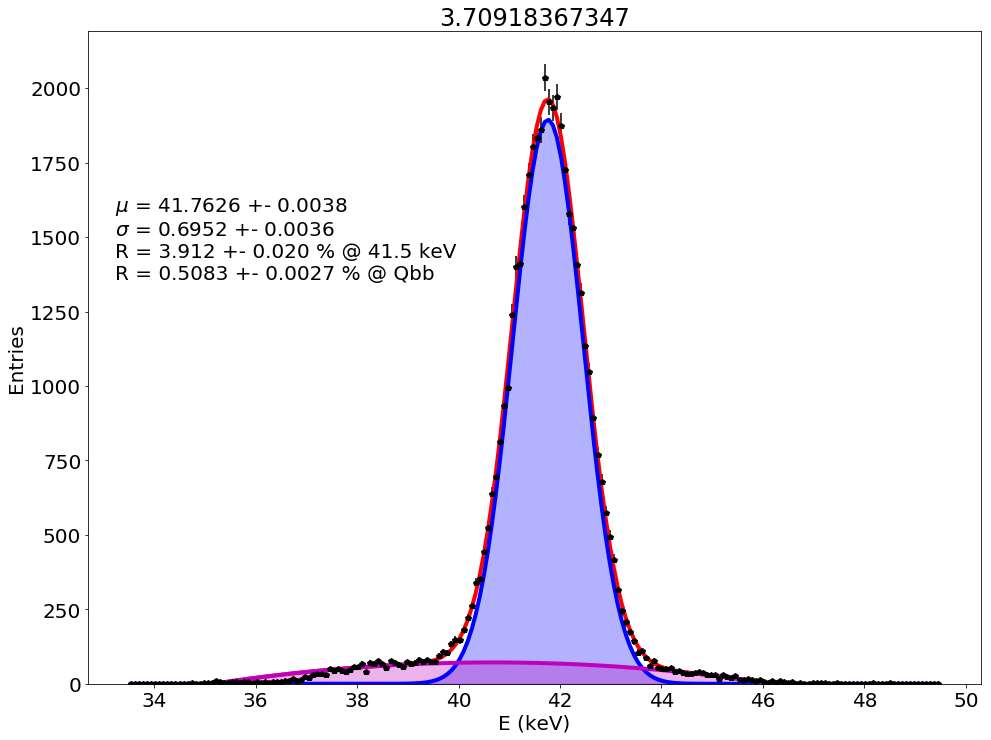

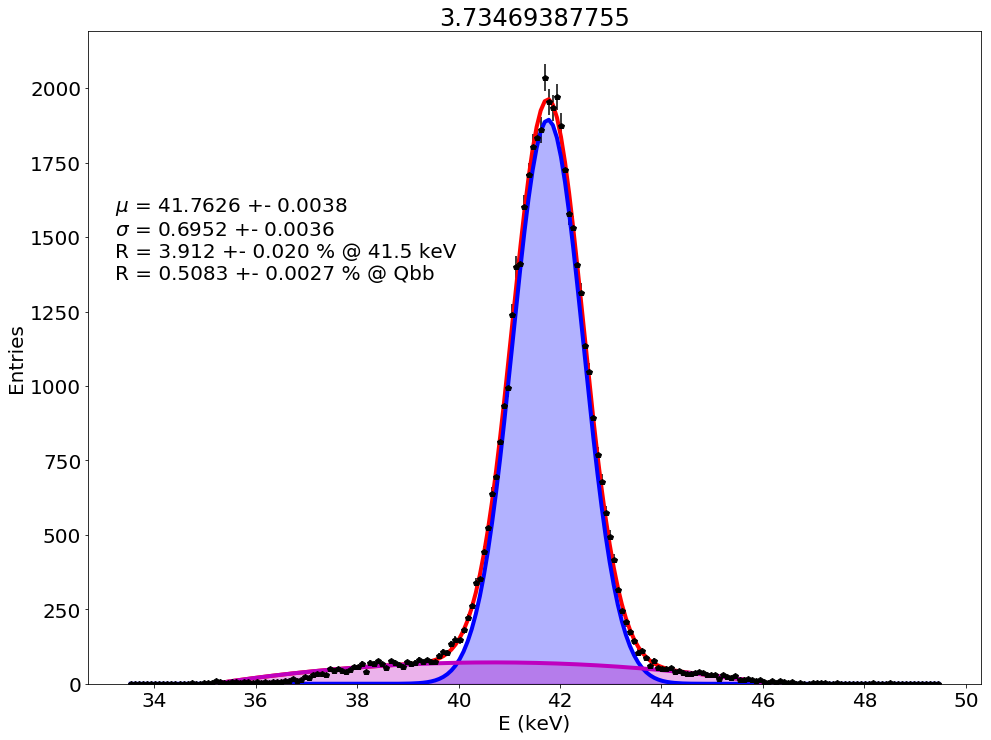

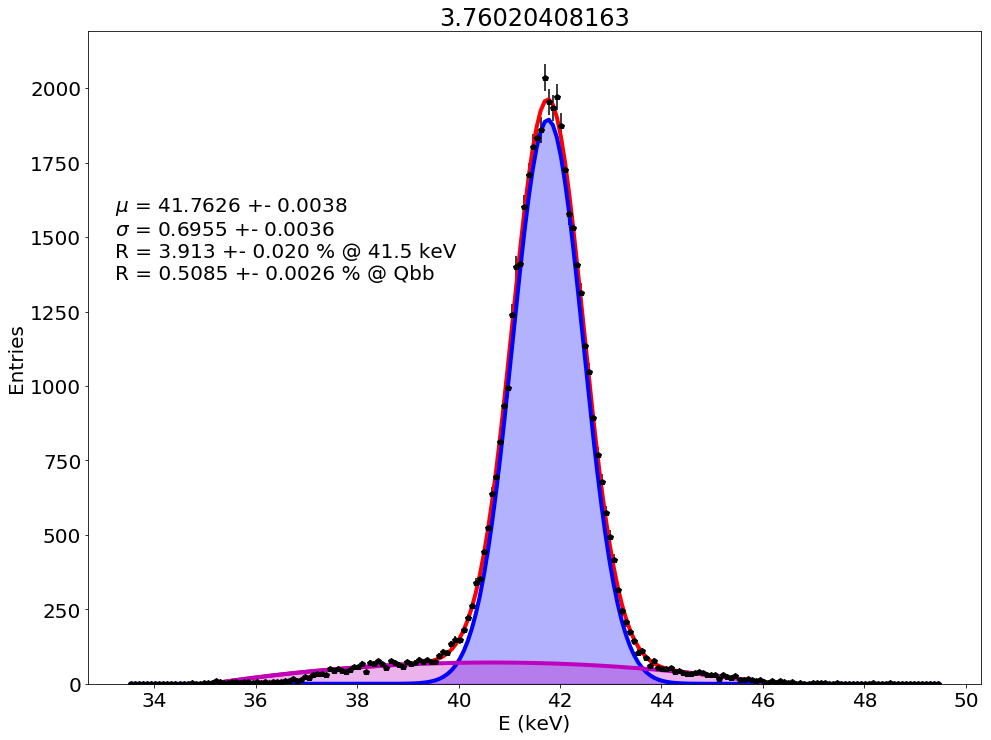

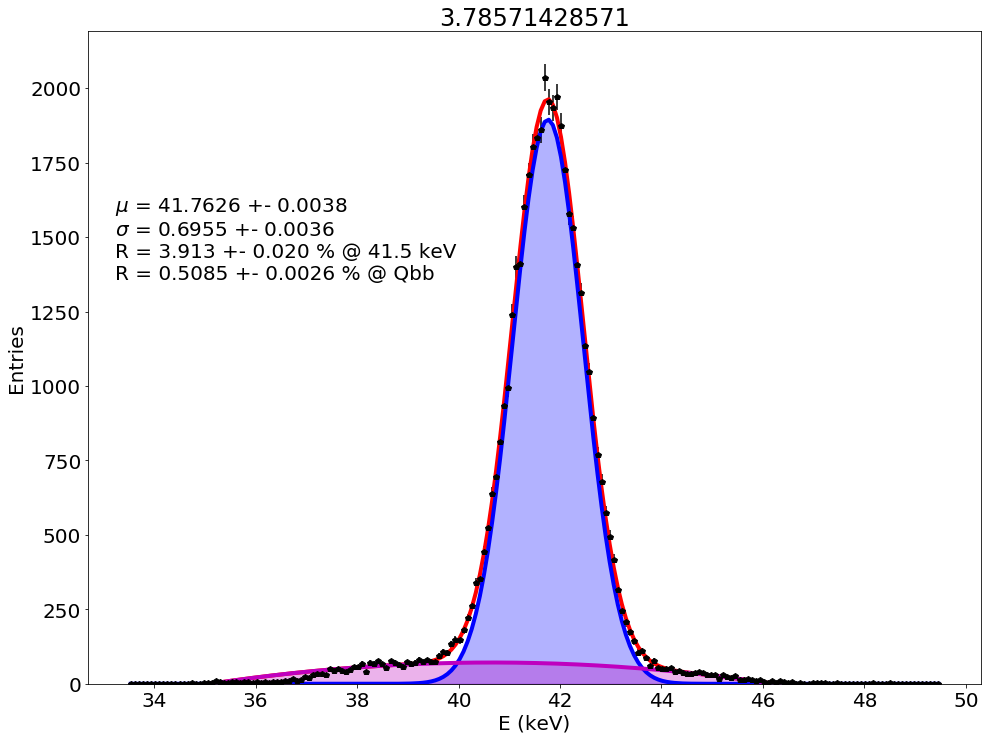

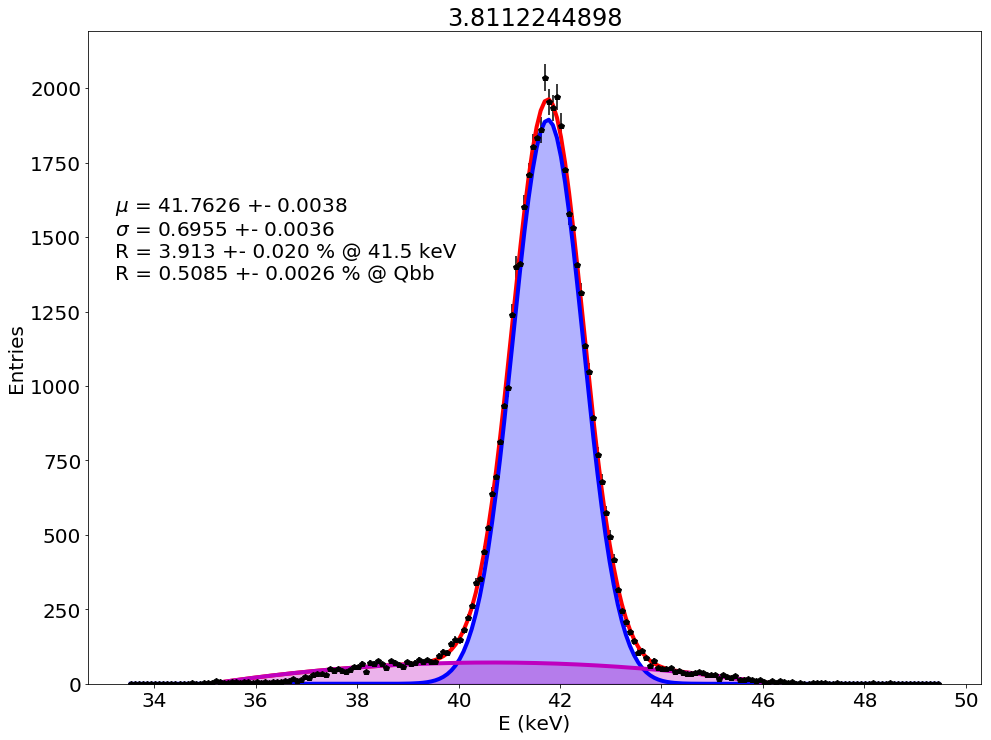

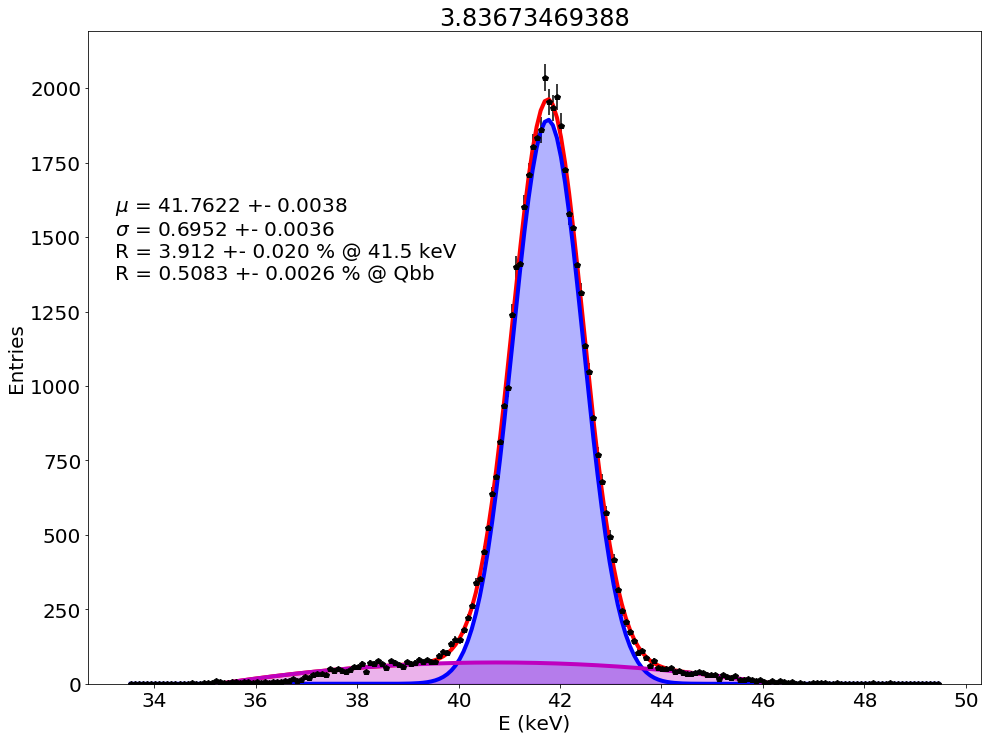

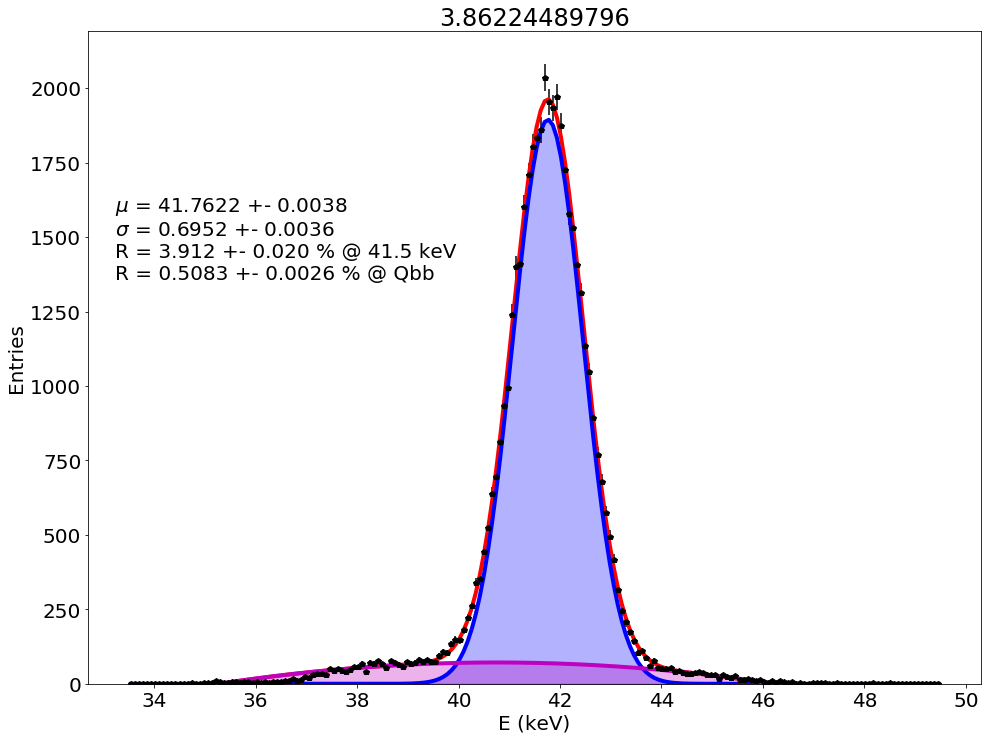

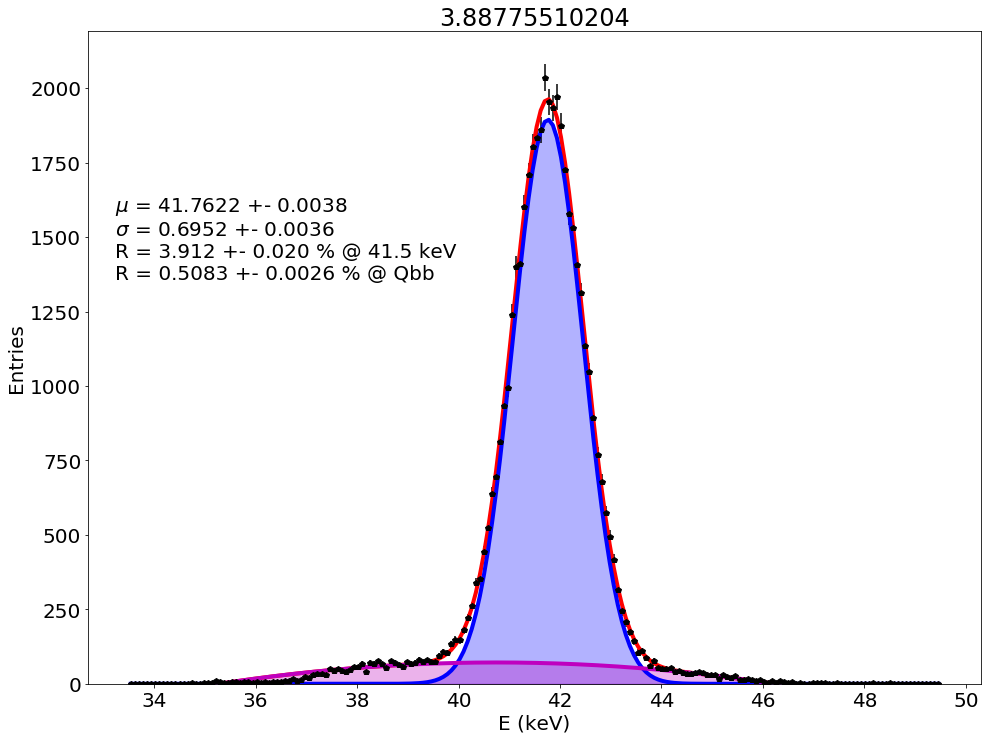

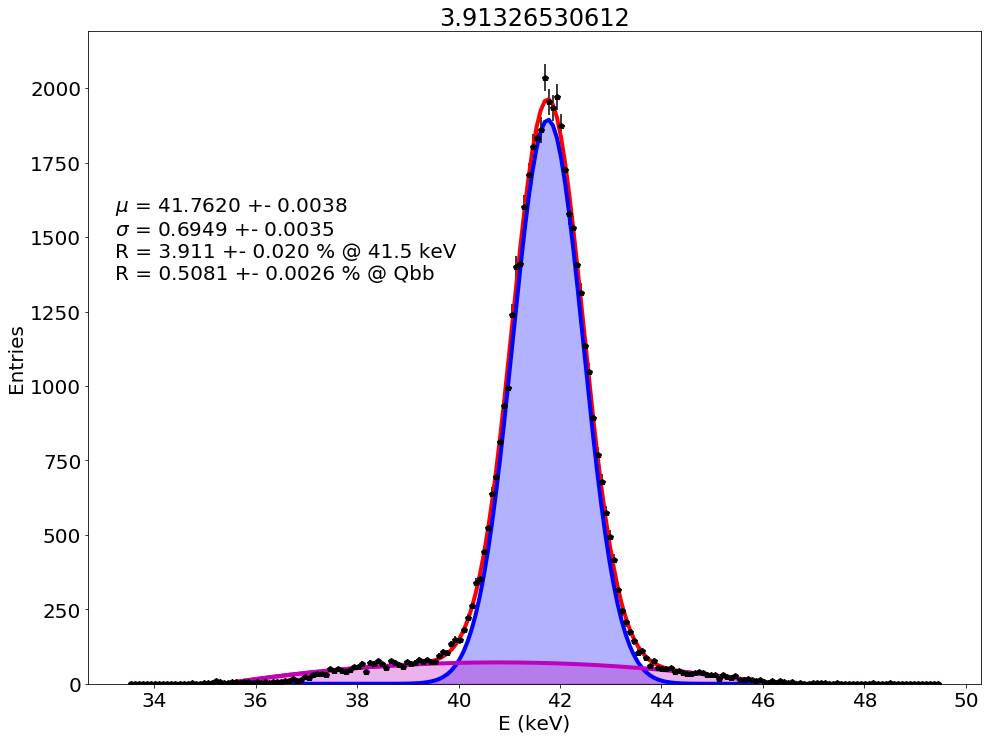

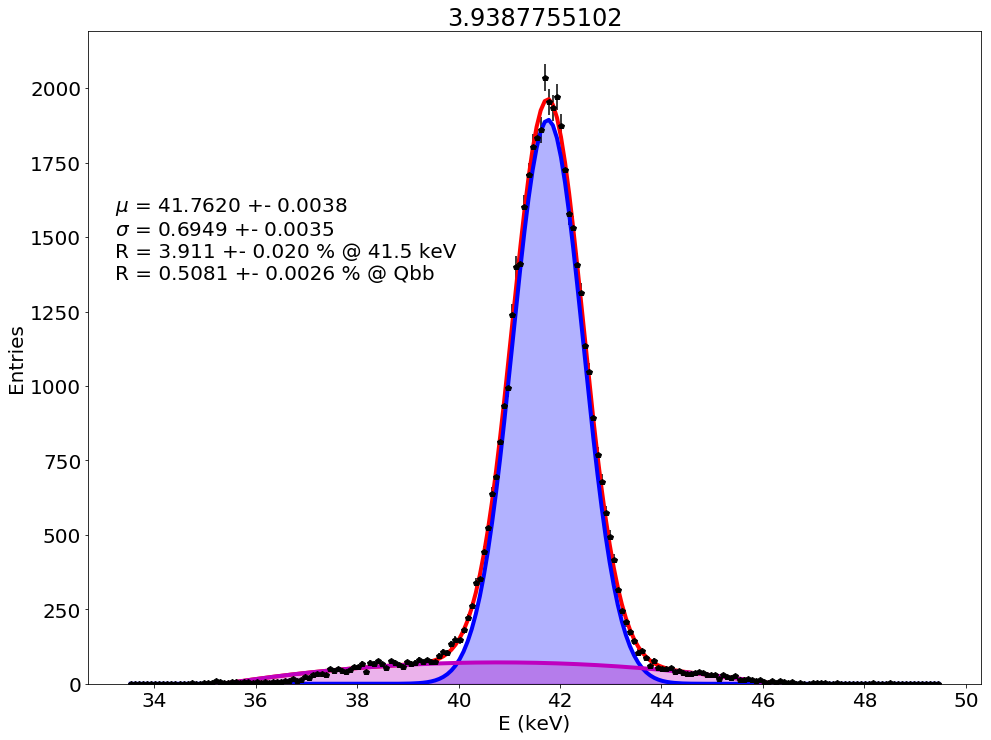

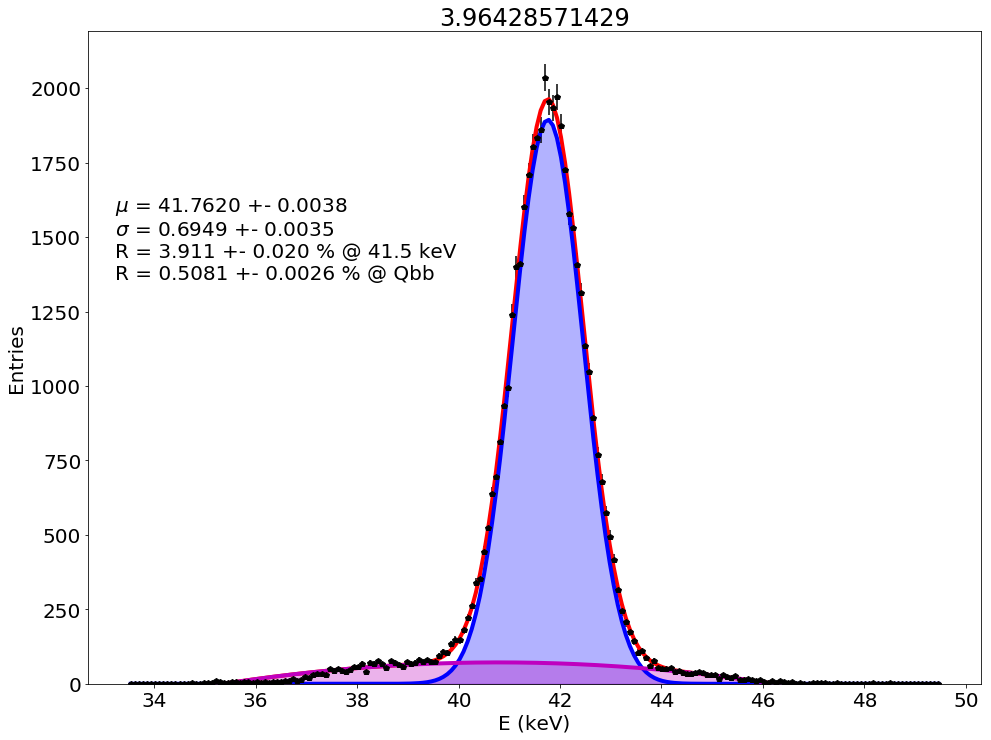

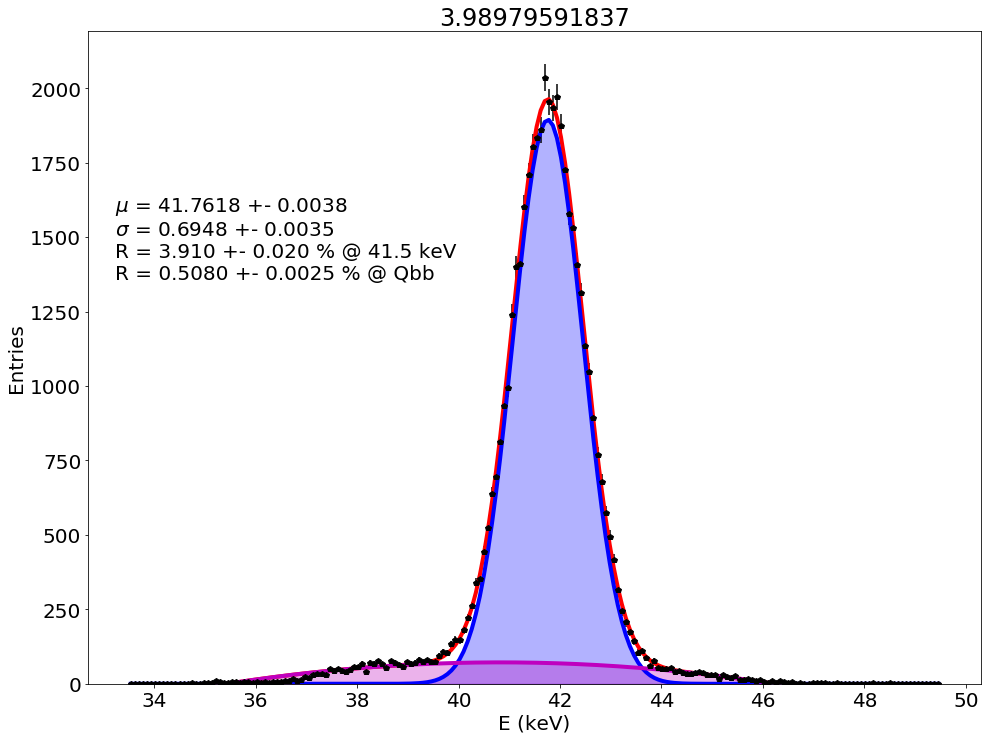

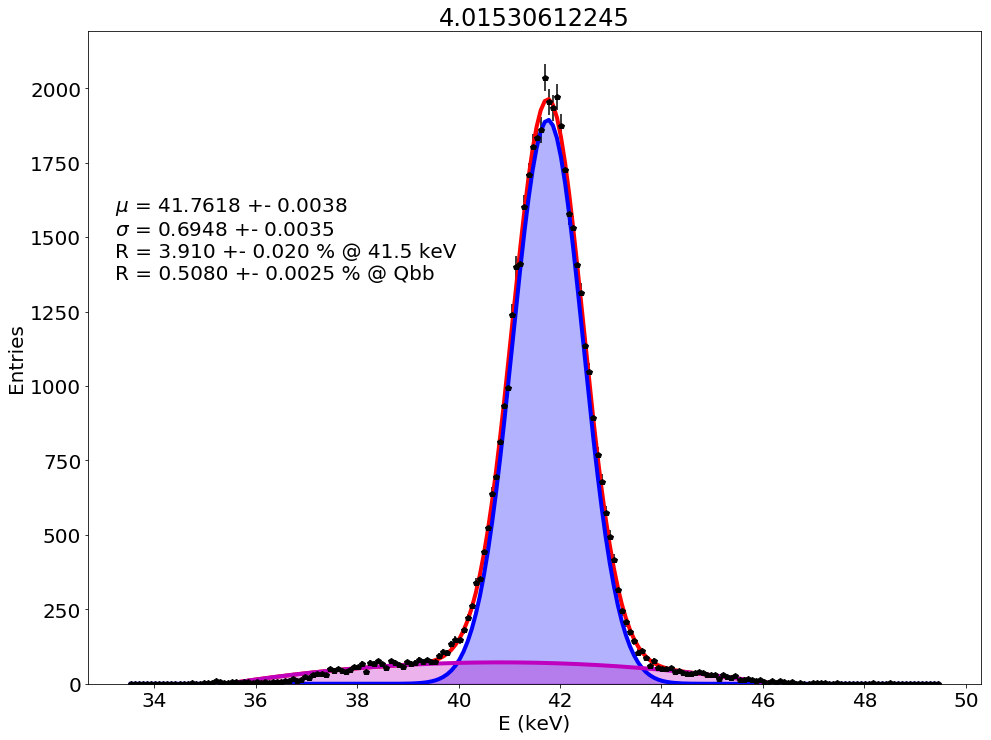

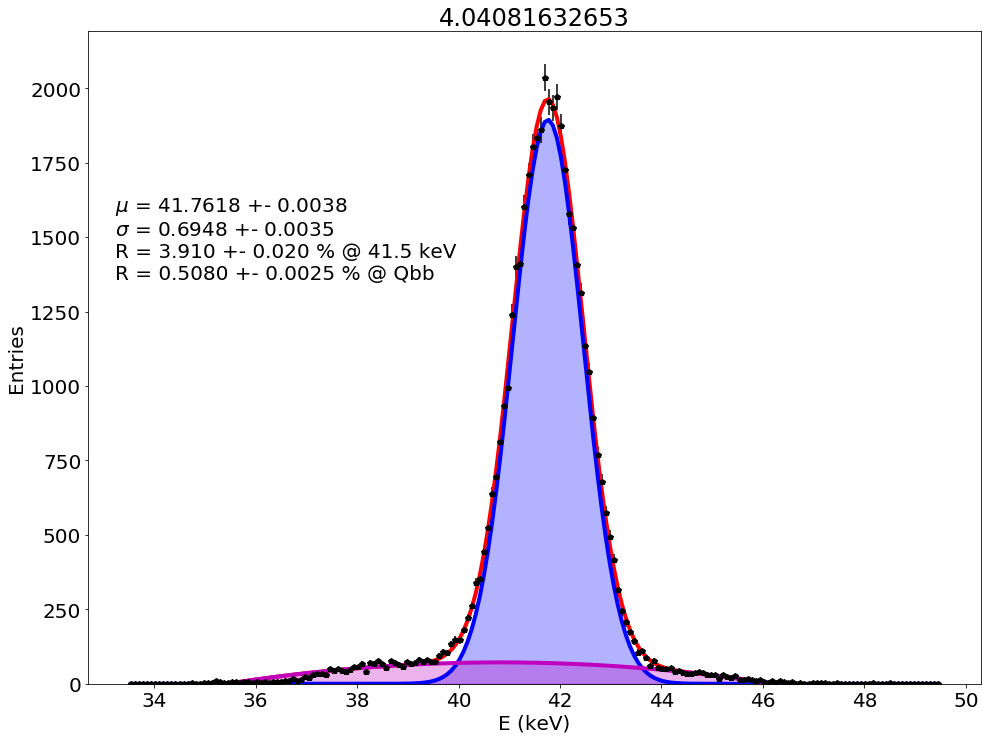

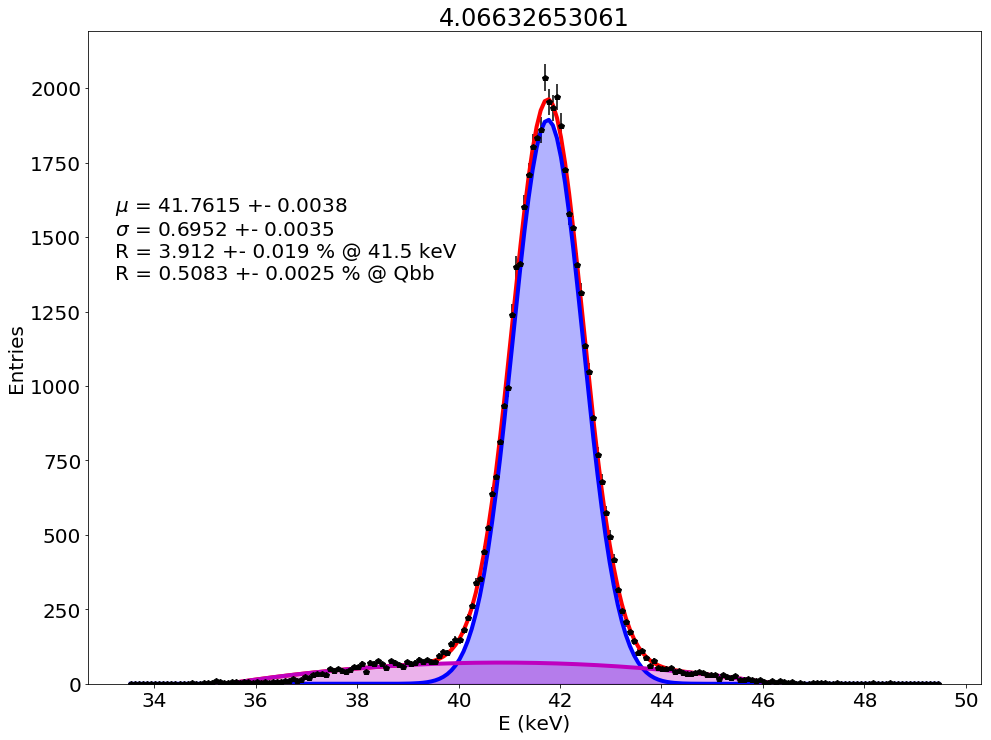

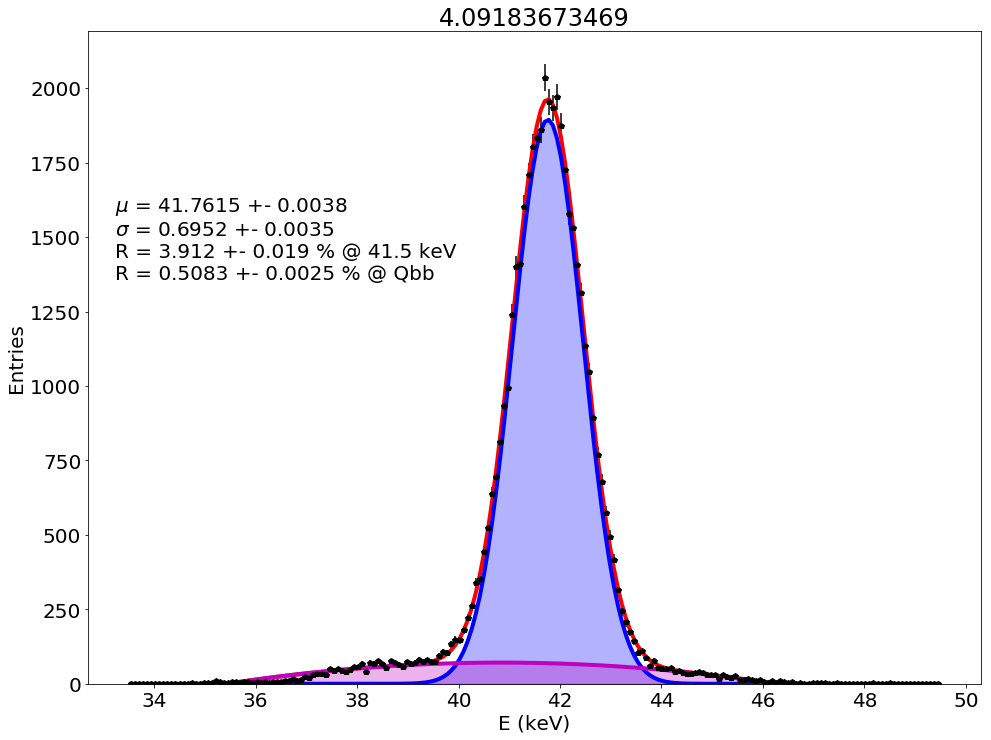

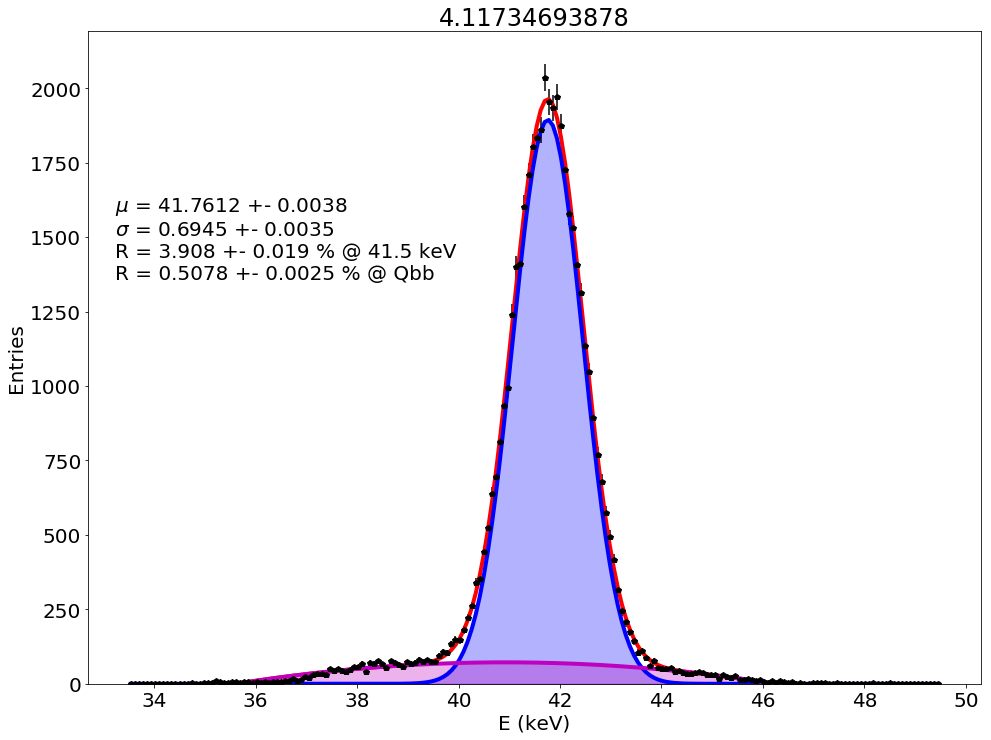

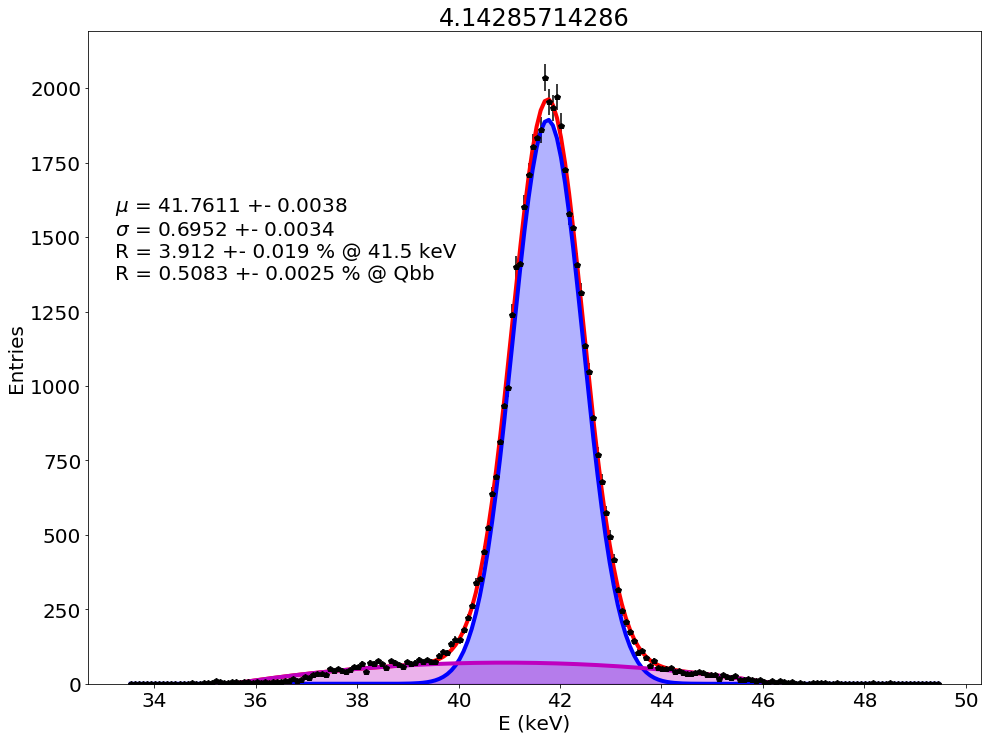

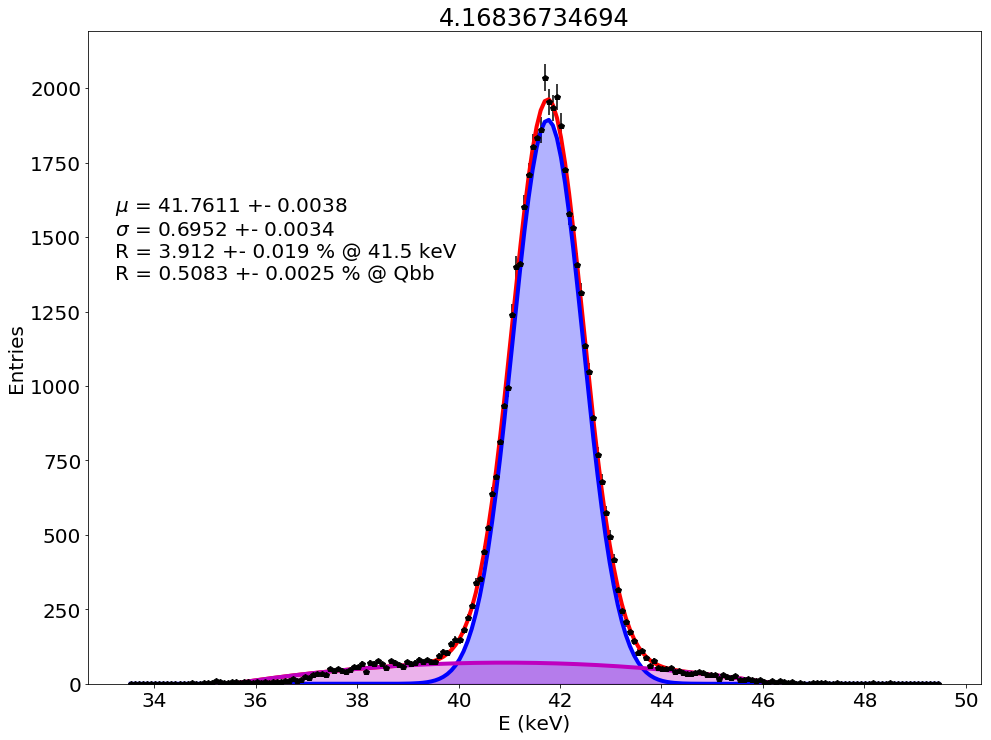

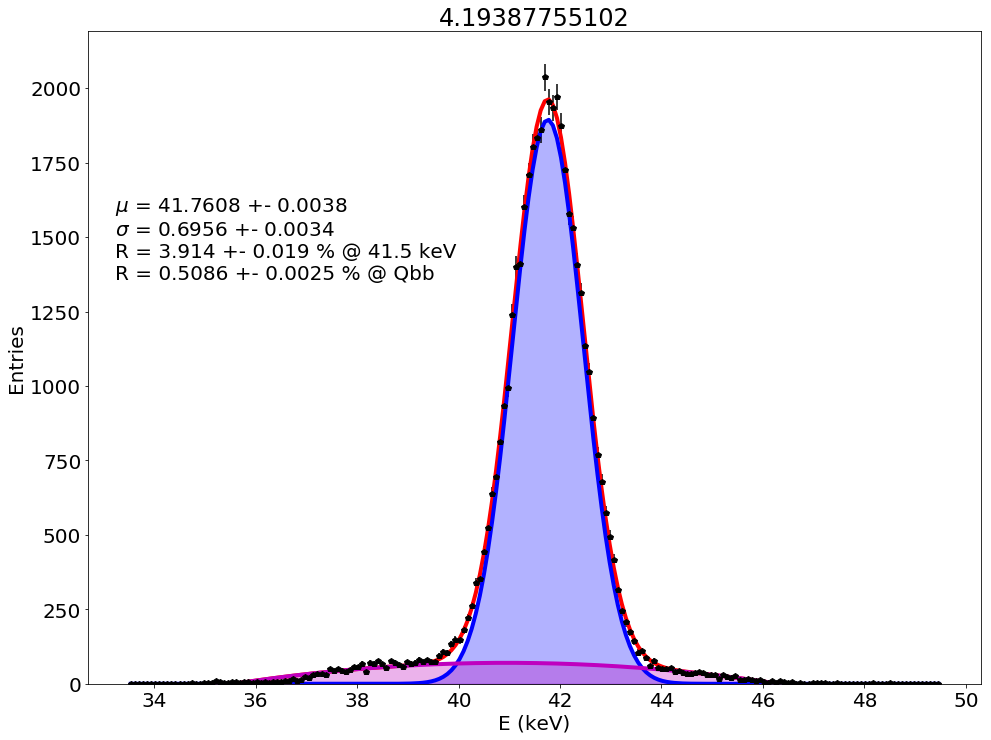

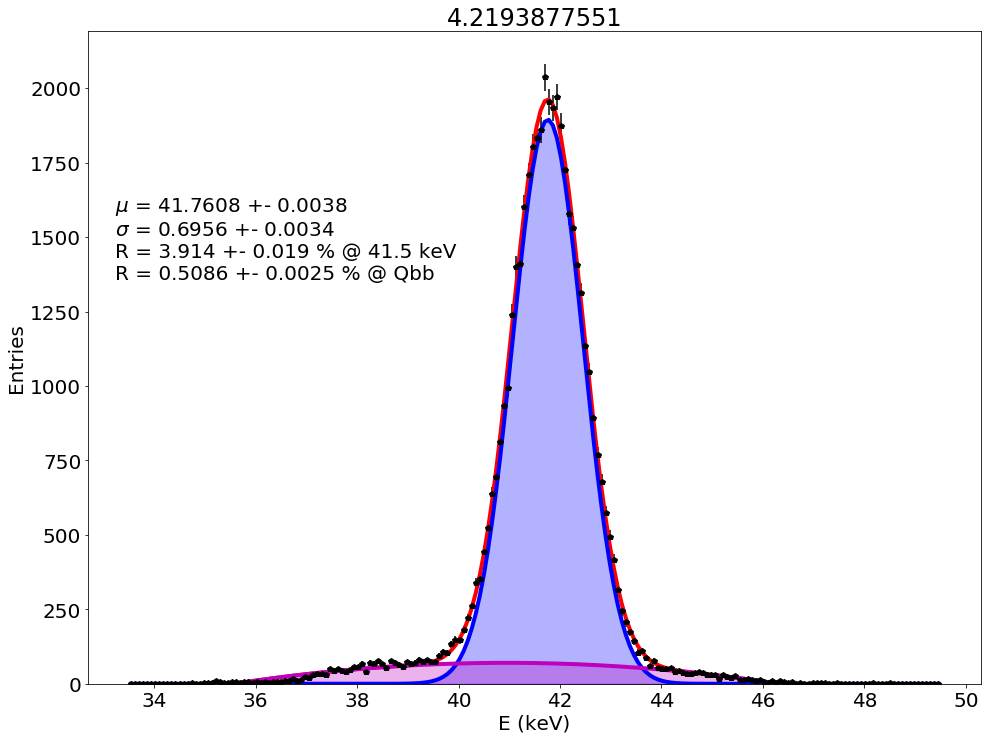

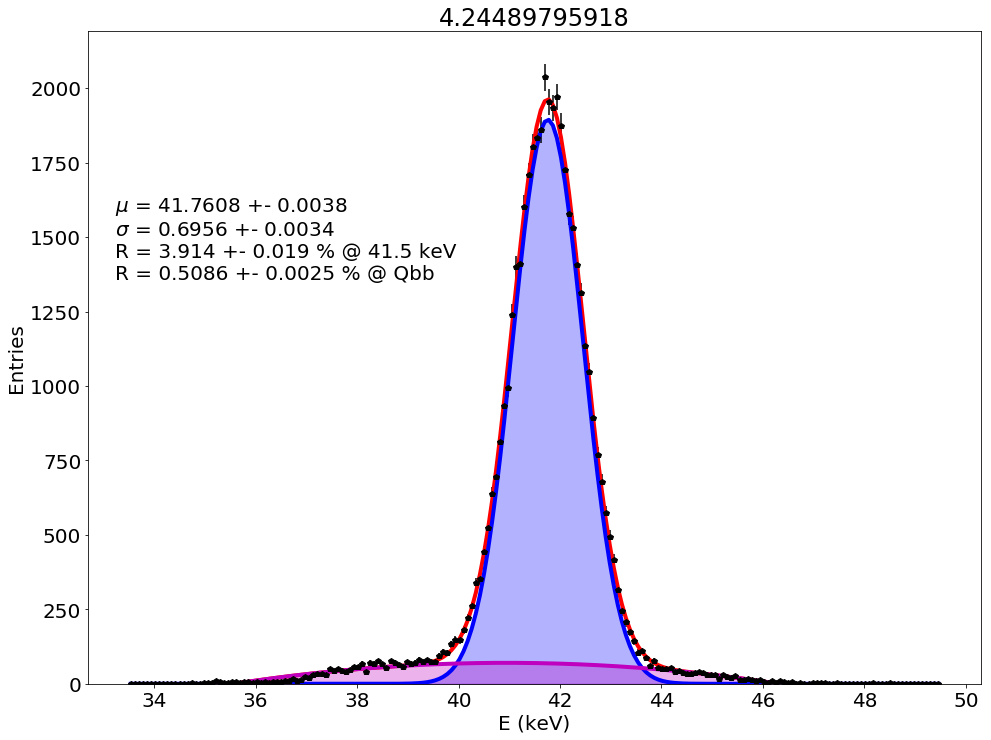

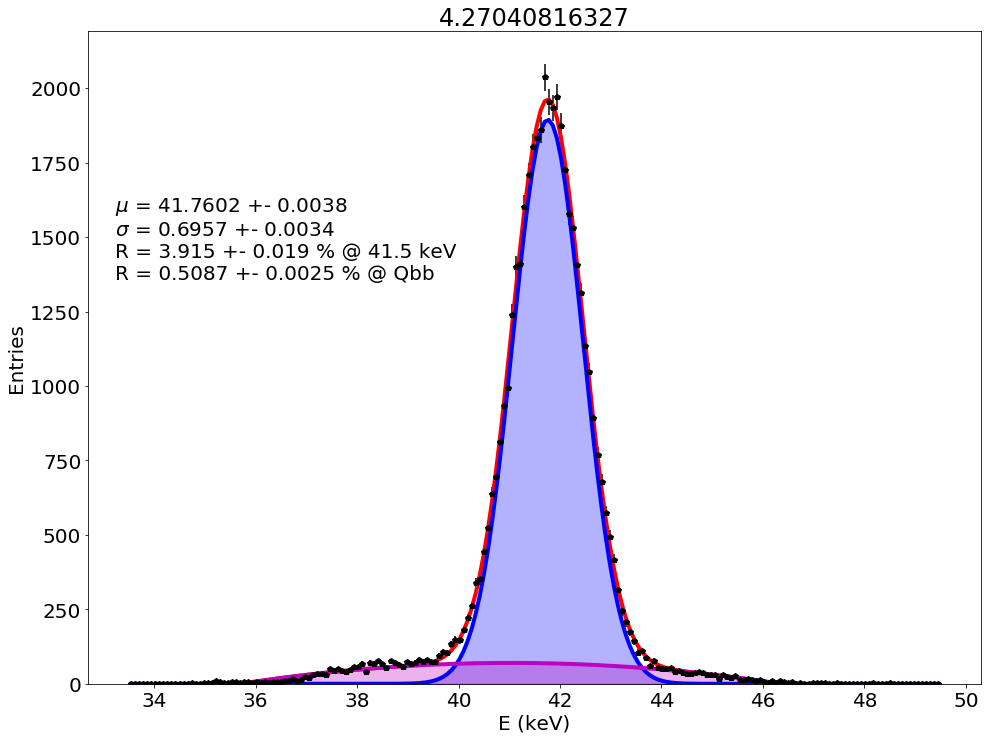

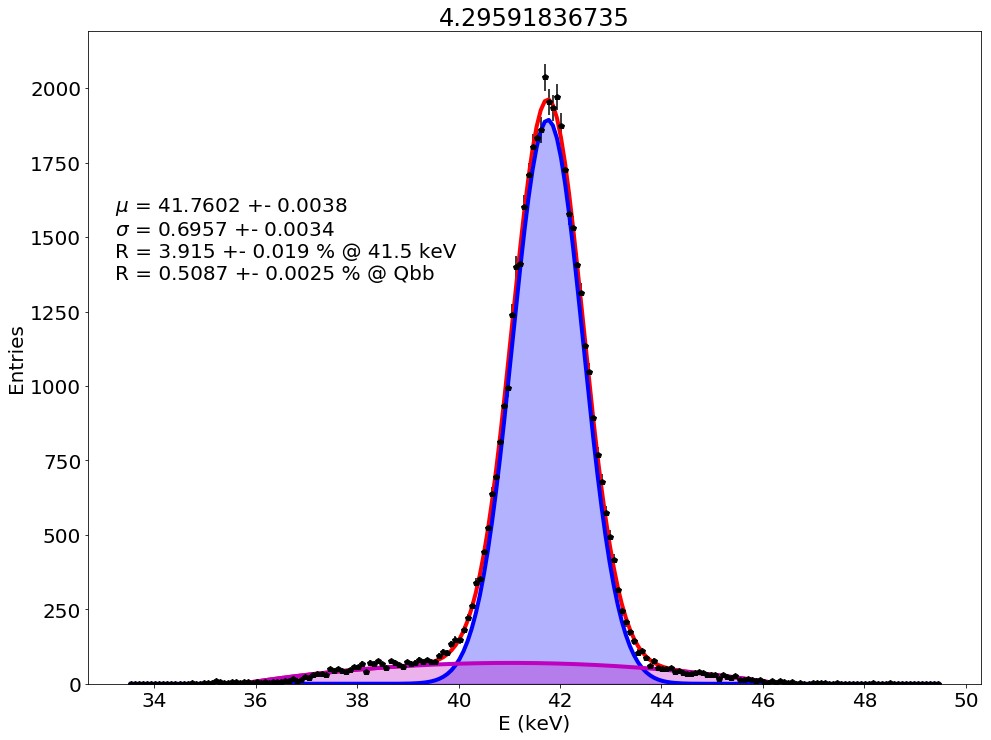

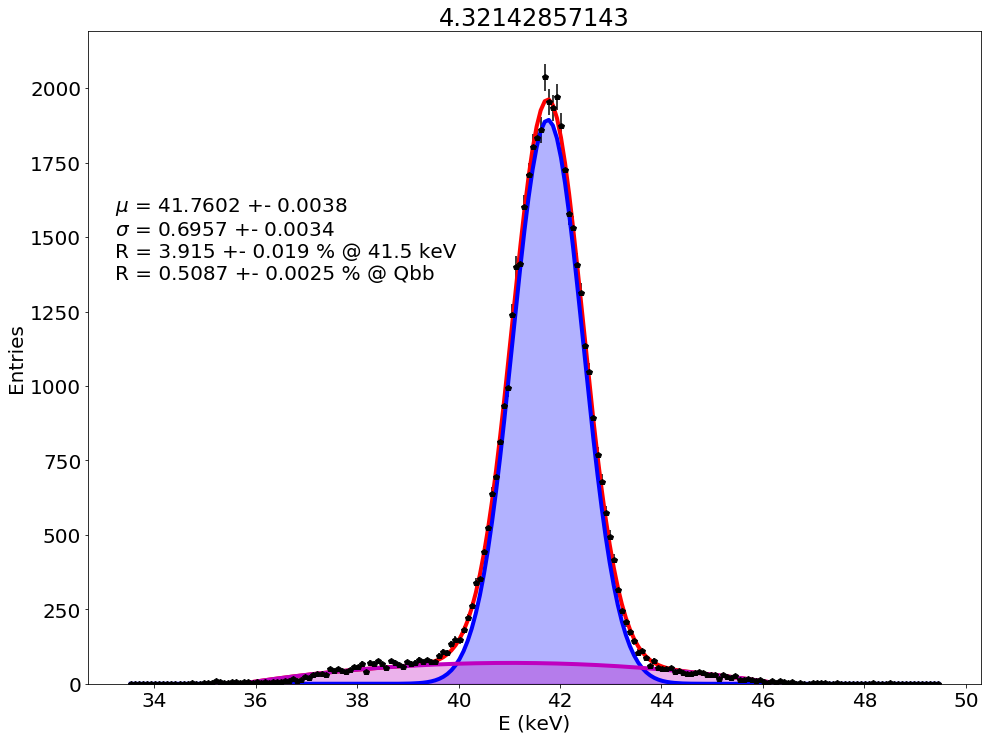

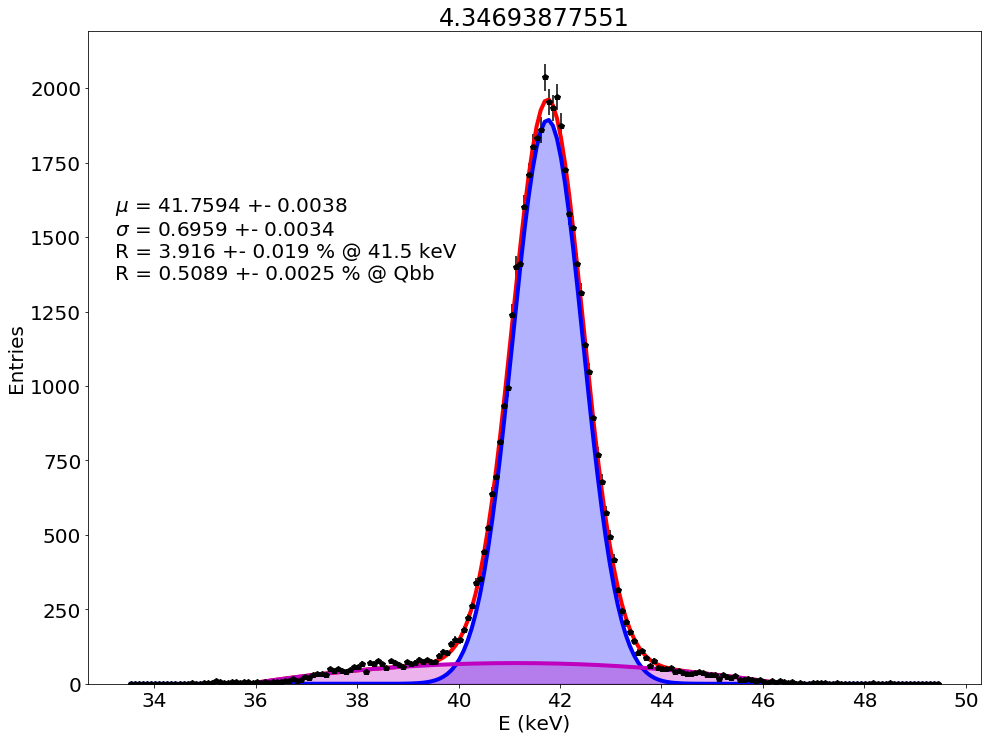

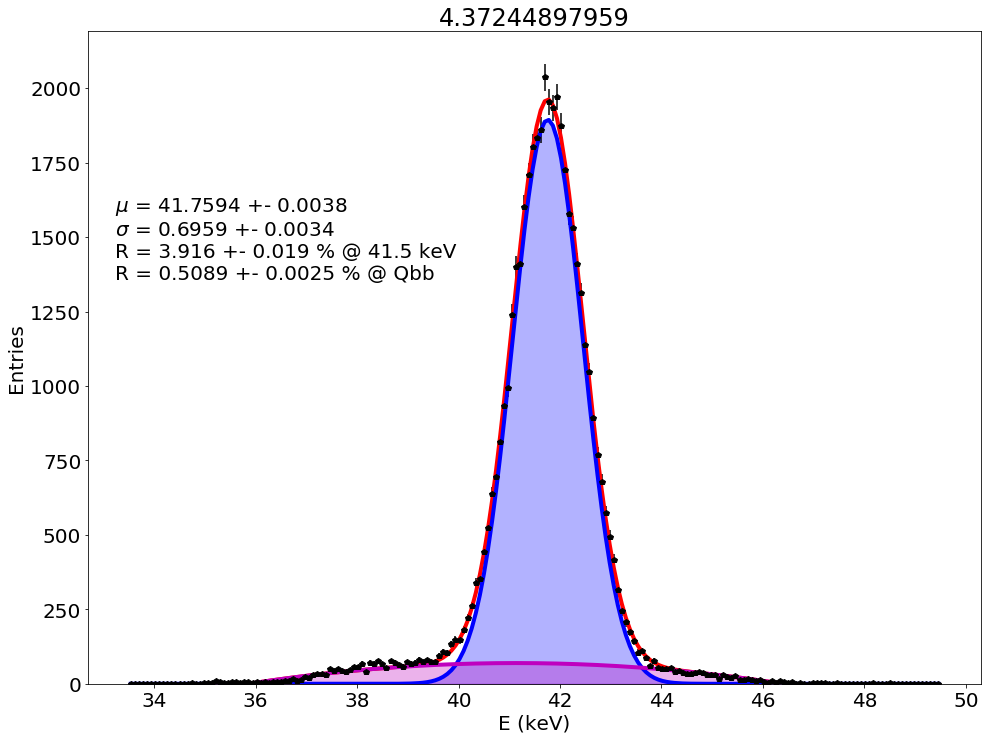

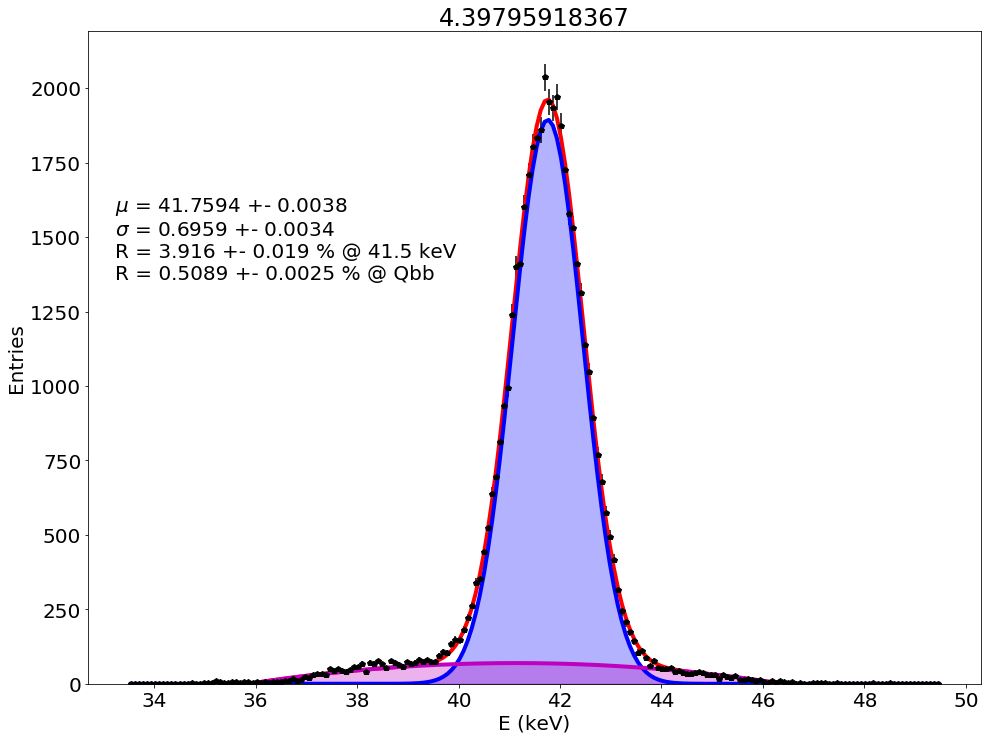

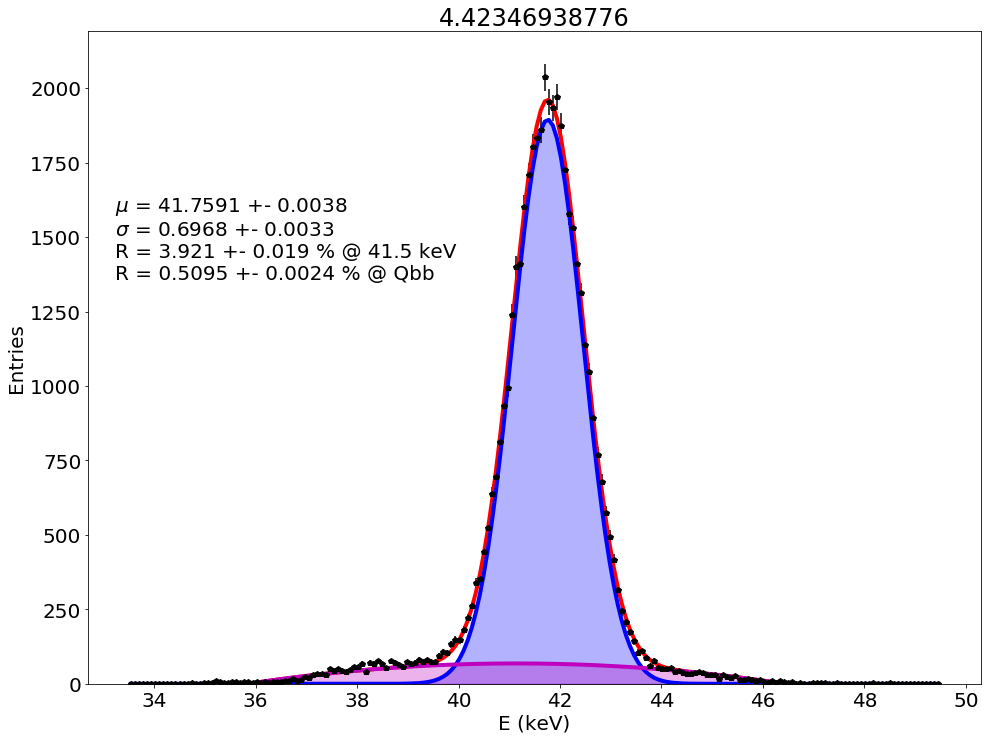

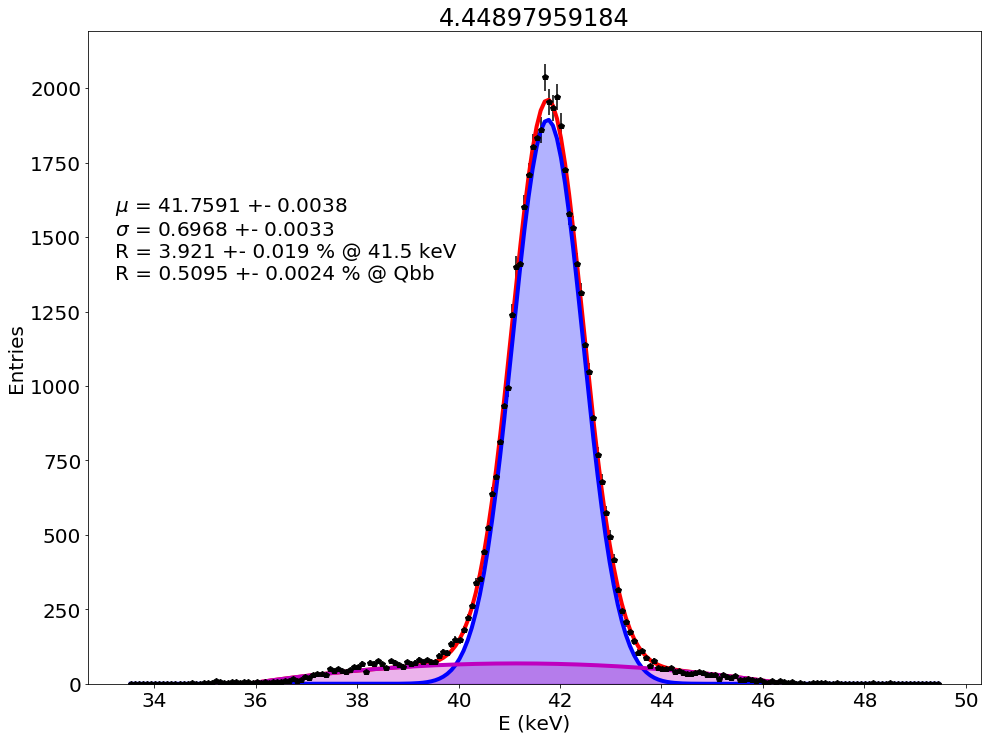

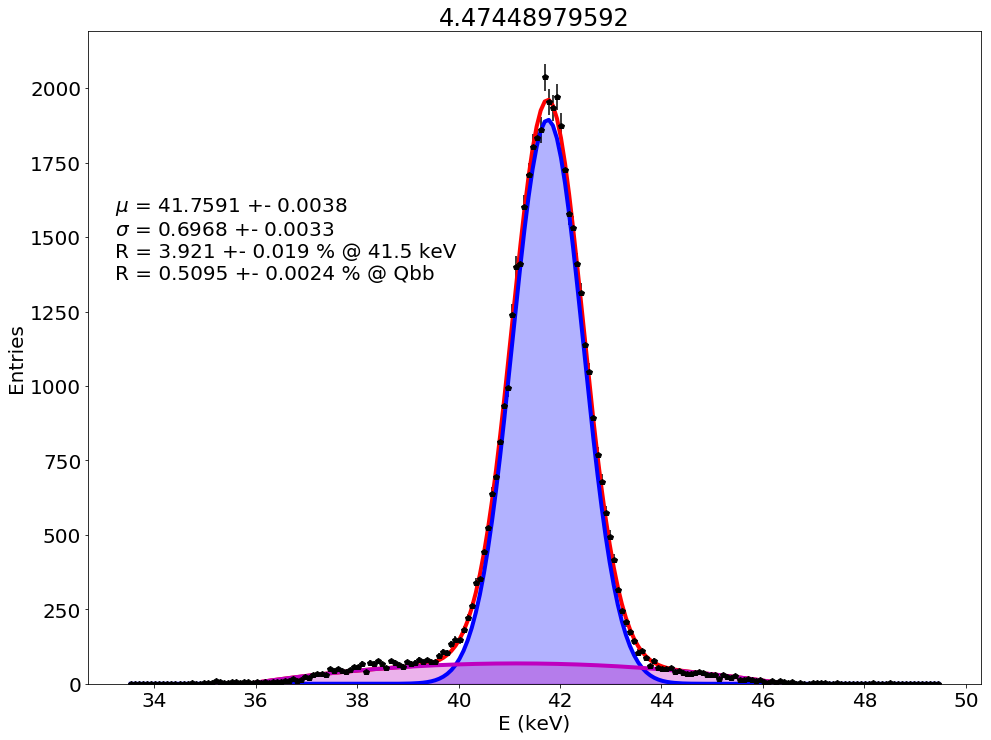

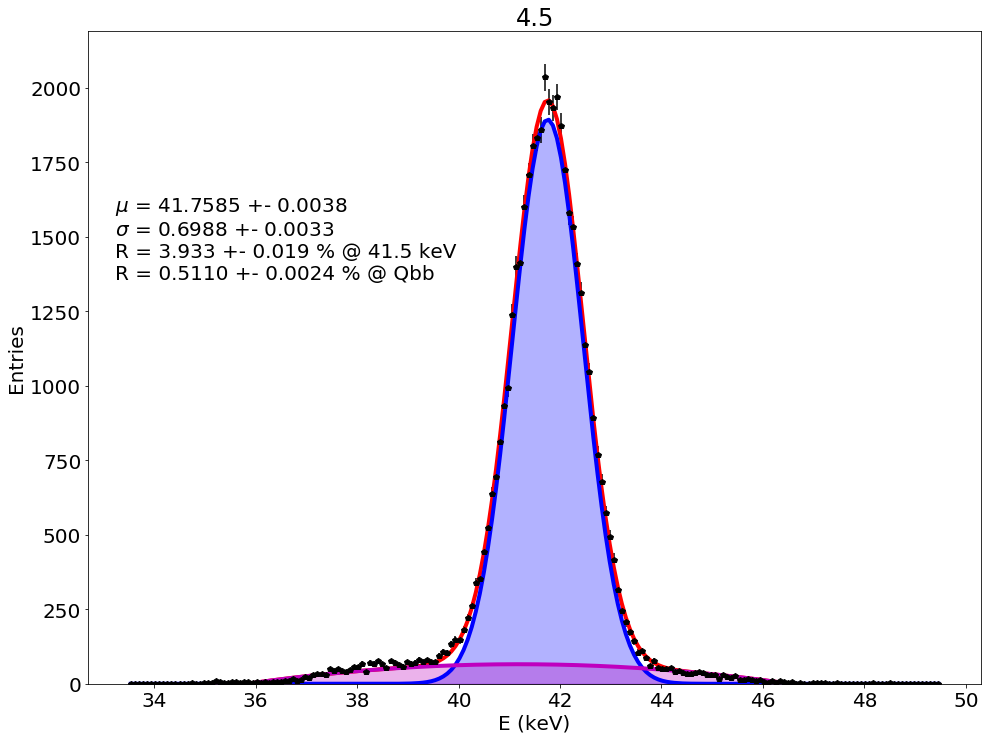

In [19]:
bkg      = fitf.polynom
nsigmas  = np.linspace(3.25, 4.5, 50)
R_range  = np.zeros(nsigmas.size)
Ru_range = np.zeros(nsigmas.size)
for i, n in enumerate(nsigmas):
    data = measure_resolution(E, bkg=bkg, n_sigma=n)
    plt.figure()
    plot(data, bkg=bkg)
    plt.title(str(n))
    R_range[i], Ru_range[i] = data.R[0]

0.00573420218502
3.91075753904
-2.69821329399e-05


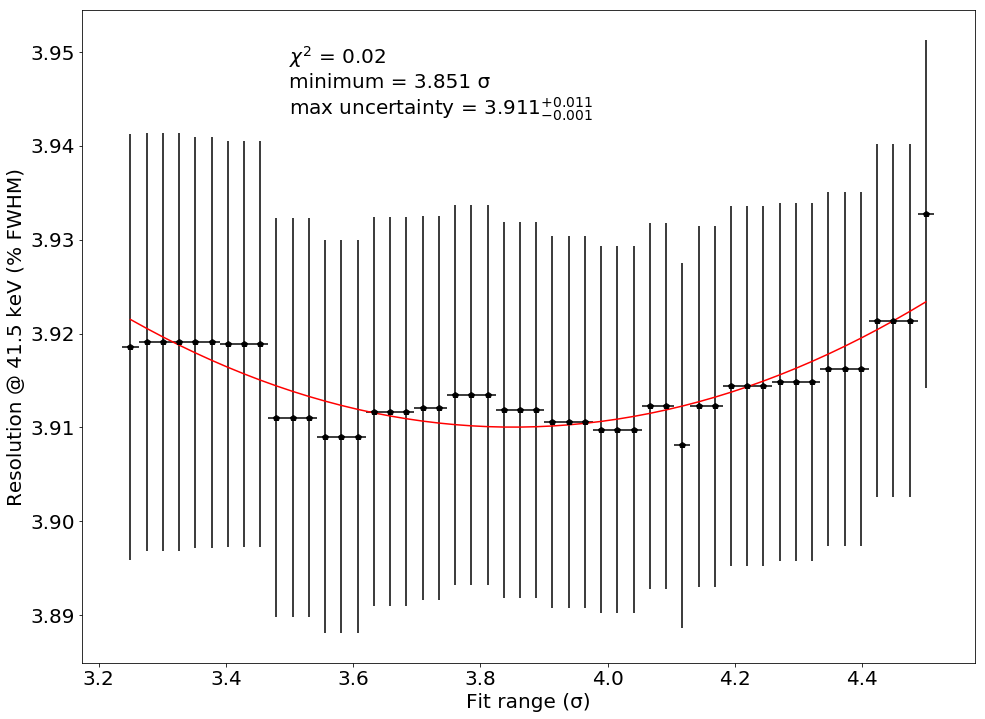

In [20]:
seed = np.ones(3)
f = fitf.fit(fitf.polynom, nsigmas, R_range, seed, sigma=Ru_range)

min_data = opt.minimize(           f.fn   , 0, bounds=((nsigmas[0], nsigmas[-1]),))
max_data = opt.minimize(lambda x: -f.fn(x), 0, bounds=((nsigmas[0], nsigmas[-1]),))
min_x    = min_data.x[0]
max_x    = max_data.x[0]
min_y    = f.fn(min_x)
max_y    = f.fn(max_x)
reso_0   = f.fn( 3.7 )
delta_m  = abs(min_y - reso_0)
delta_p  = abs(max_y - reso_0)
print(f.fn( 3.4 ) - f.fn( 3.7 ))
print(f.fn( 3.7 ))
print(f.fn( 4.0 ) - f.fn( 3.7 ))
text = f"""
$\chi^2$ = {f.chi2:.2f}
minimum = {min_x:.3f} σ
max uncertainty = ${reso_0:.3f}_{{-{delta_m:.3f}}}^{{+{delta_p:.3f}}}$
"""

plt.errorbar(nsigmas, R_range, Ru_range, np.diff(nsigmas)[0] / 2, "pk")
plt.plot(nsigmas, f.fn(nsigmas), "r-")
plt.text(3.5, relative_to(plt.ylim(), 0.8), text)

labels("Fit range (σ)", "Resolution @ 41.5 keV (% FWHM)")

### Background model systematics

gauss
Resolution at 41.5 keV: 3.895 +- 0.022
Resolution at 2458 keV: 0.5061 +- 0.0029
Chi2                  : 1.03297697877
0th degree pol
Resolution at 41.5 keV: 4.055 +- 0.017
Resolution at 2458 keV: 0.5269 +- 0.0022
Chi2                  : 5.79475189858
1st degree pol
Resolution at 41.5 keV: 4.022 +- 0.017
Resolution at 2458 keV: 0.5226 +- 0.0023
Chi2                  : 2.11959274988
2nd degree pol
Resolution at 41.5 keV: 3.912 +- 0.020
Resolution at 2458 keV: 0.5083 +- 0.0027
Chi2                  : 1.0987639705
3rd degree pol
Resolution at 41.5 keV: 3.907 +- 0.021
Resolution at 2458 keV: 0.5076 +- 0.0027
Chi2                  : 1.0006860299
4th degree pol
Resolution at 41.5 keV: 3.928 +- 0.027
Resolution at 2458 keV: 0.5104 +- 0.0035
Chi2                  : 0.996095036451
5th degree pol
Resolution at 41.5 keV: 3.927 +- 0.027
Resolution at 2458 keV: 0.5103 +- 0.0035
Chi2                  : 0.99917519793


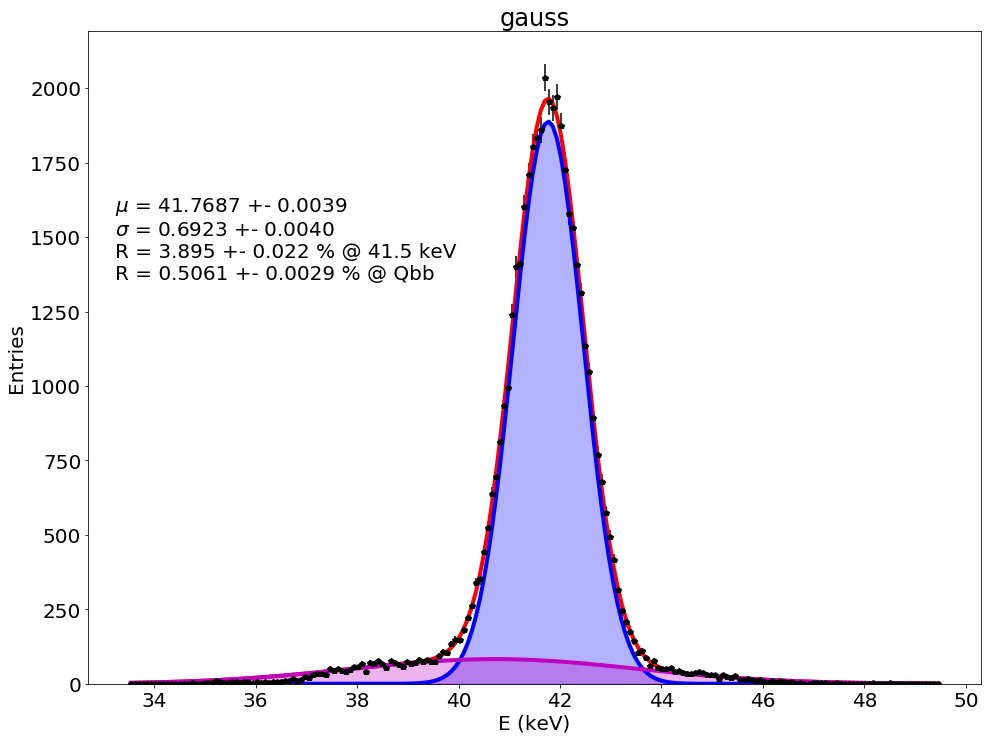

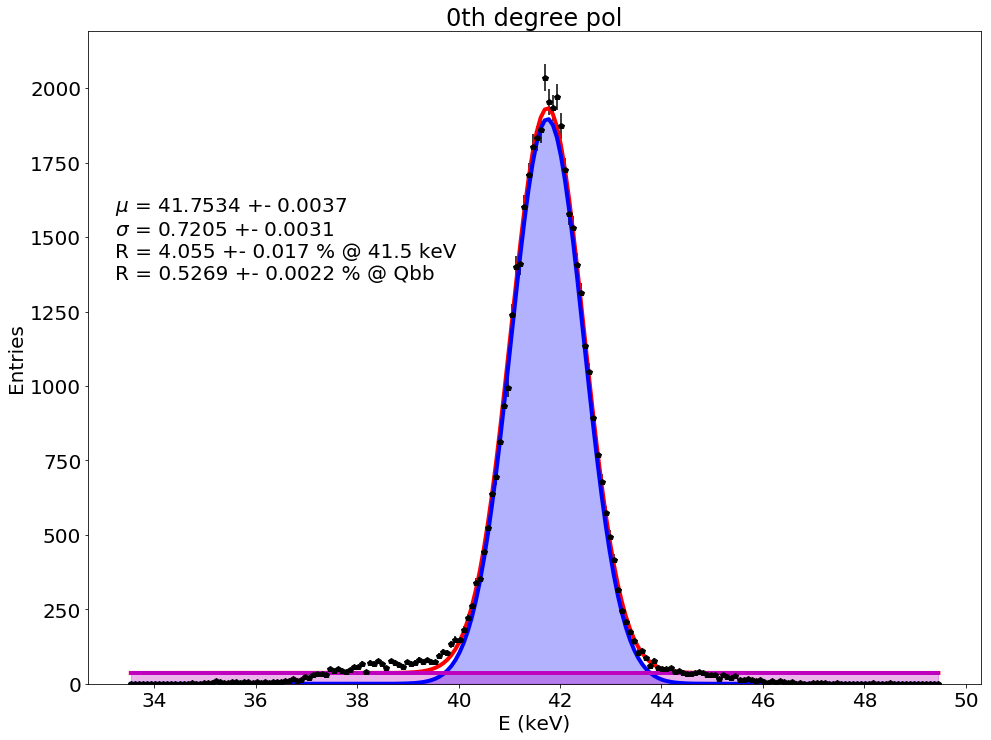

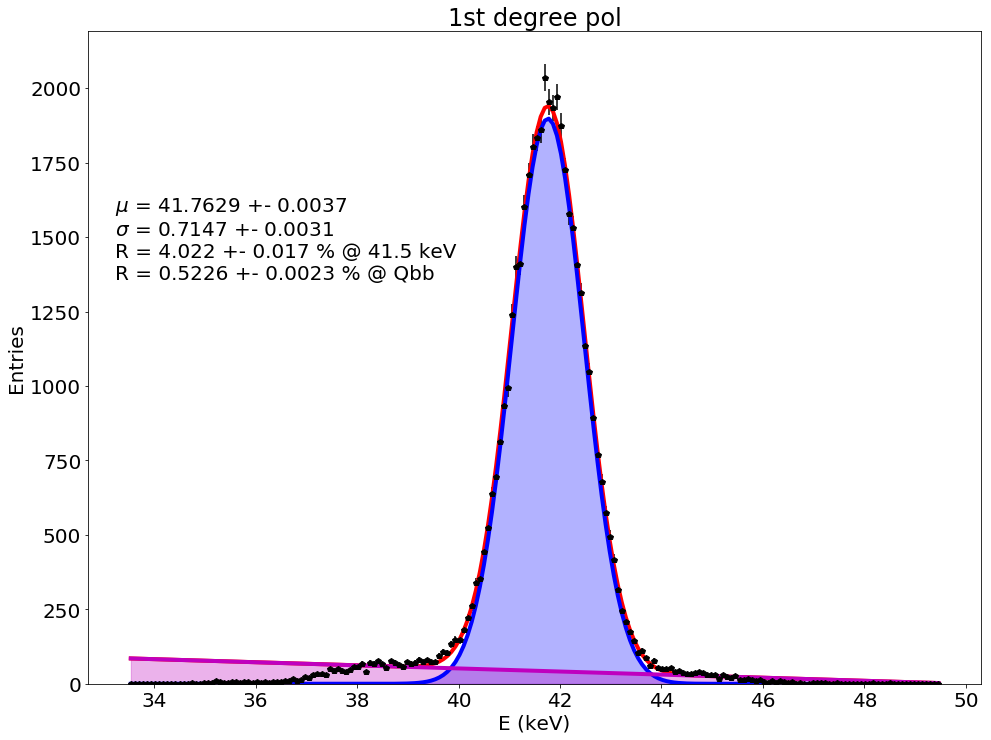

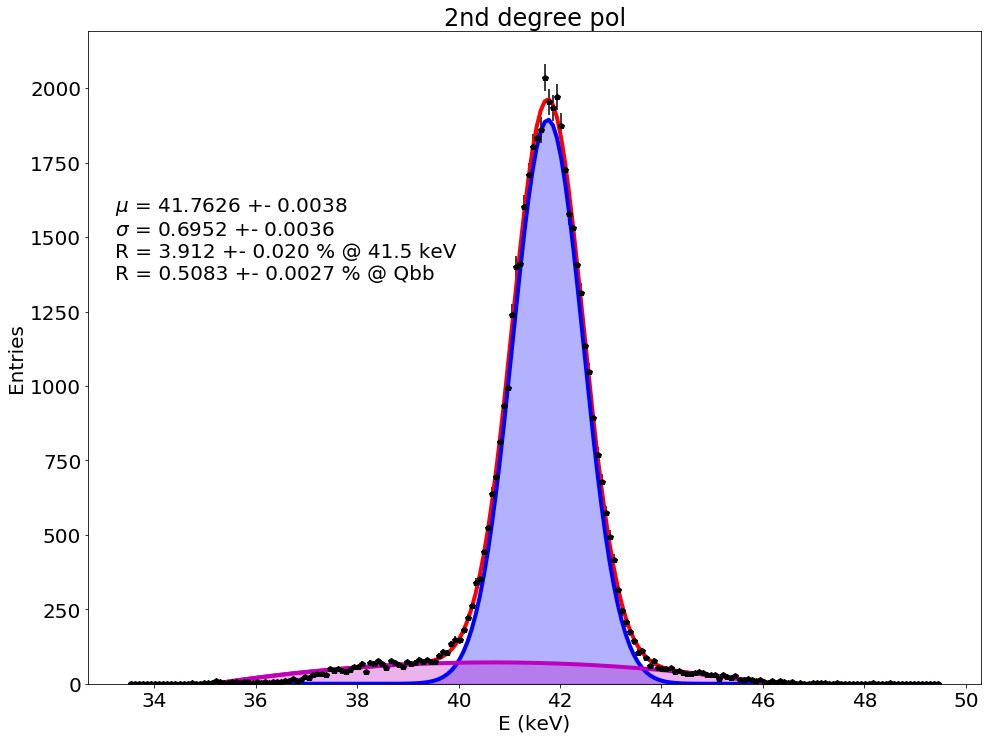

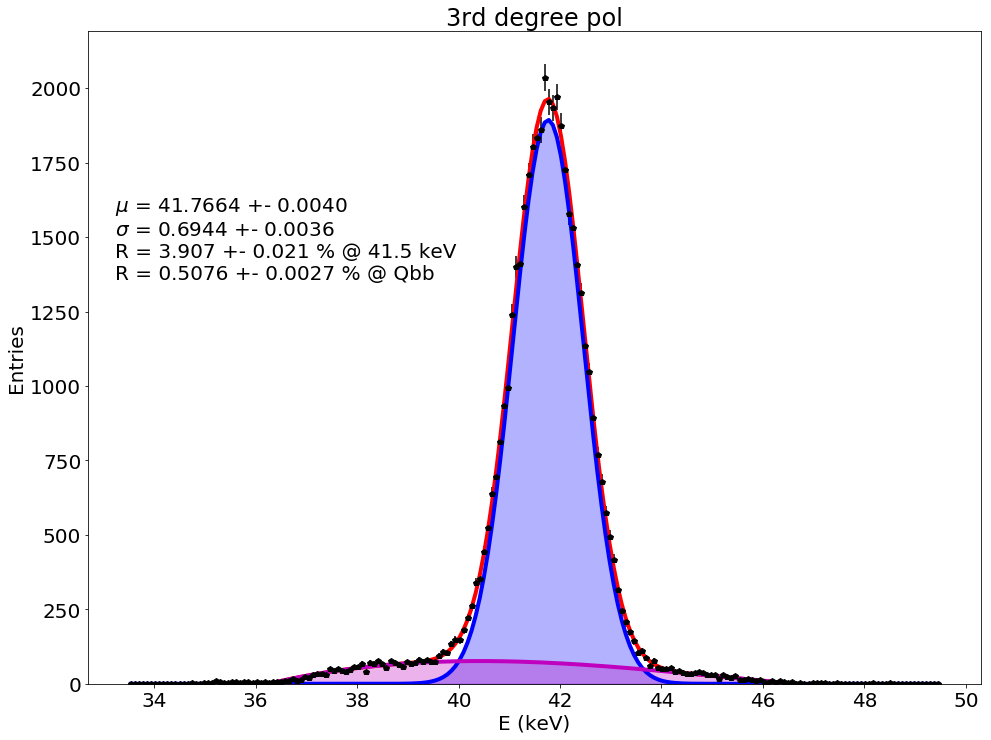

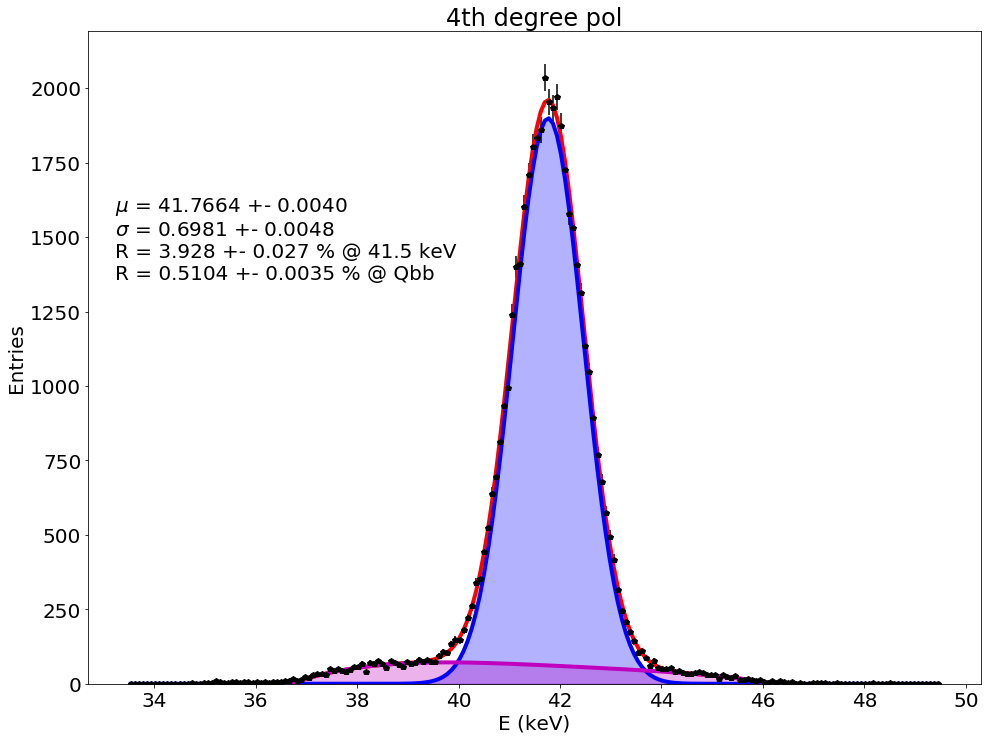

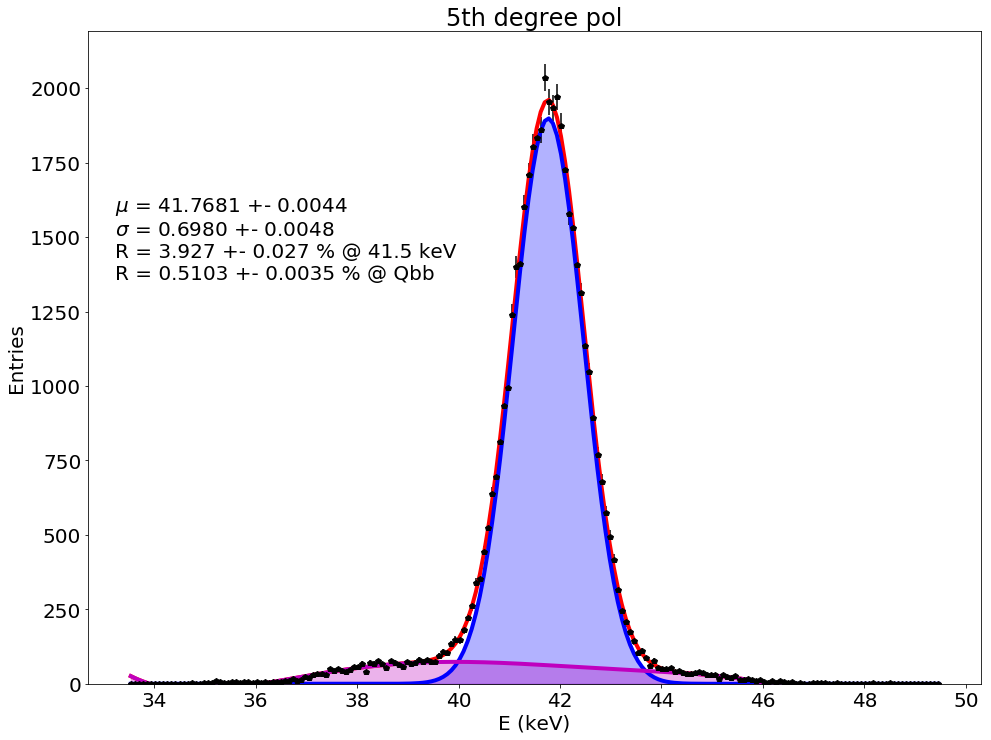

In [35]:
models   = {"gauss"         : dict(bkg = fitf.gauss            ),
            "0th degree pol": dict(bkg = fitf.polynom, degree=0),
            "1st degree pol": dict(bkg = fitf.polynom, degree=1),
            "2nd degree pol": dict(bkg = fitf.polynom, degree=2),
            "3rd degree pol": dict(bkg = fitf.polynom, degree=3),
            "4th degree pol": dict(bkg = fitf.polynom, degree=4),
            "5th degree pol": dict(bkg = fitf.polynom, degree=5)}
R_model  = {}
Ru_model = {}
for name, model in models.items():
    print(name)
    data = measure_resolution(E, **model)
    R_model[name], Ru_model[name] = data.R[0]
    plt.figure()
    plot(data, bkg=model["bkg"], title=name)
    plt.ylim(*true_ylim)

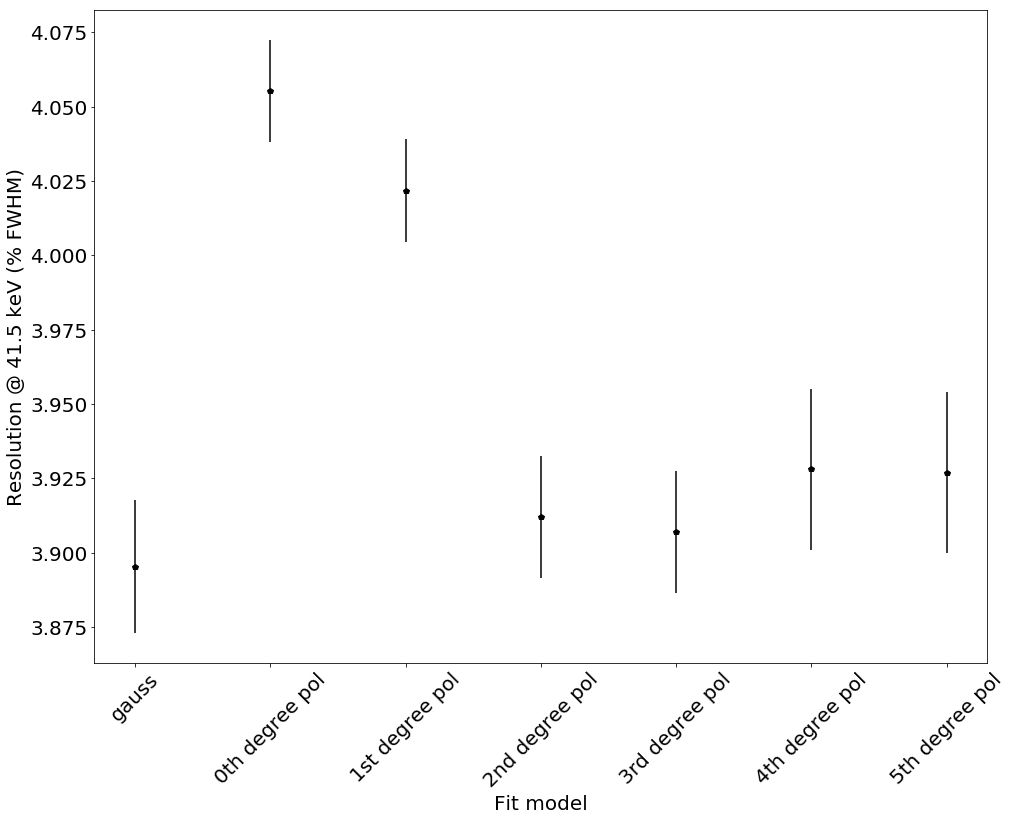

In [36]:
labels_, r, ru = zip(*((m, R_model[m], Ru_model[m]) for m in models))
xticks = np.arange(len(labels_))
plt.errorbar(xticks, r, ru, fmt="pk")
plt.gca().set_xticks     (xticks )
plt.gca().set_xticklabels(labels_)
plt.xticks(rotation=45)
labels("Fit model", "Resolution @ 41.5 keV (% FWHM)")

In [38]:
R_model["2nd degree pol"] - R_model["0th degree pol"]

-0.14316662987193451